<a href="https://colab.research.google.com/github/RayBasilio123/WaveNet/blob/master/Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Time Series Forecasting - Exploration of various techniques**



# Time-Series: ETF 'VUKE' prices

As an example, we use the price of the ETF 'VUKE' 
(Vanguard FTSE 100 UCITS ETF GBP Dis) which seeks to track the performance of the FTSE 100 Index.


**Table of Contents**

>[Time-Series: ETF 'VUKE' prices](#scrollTo=_kP_P5RKdXWk)

>>[Import dependencies](#scrollTo=OopiVLlmlrgs)

>>[Get the data](#scrollTo=UgKcWHwjnlwz)

>>[Define the time-series](#scrollTo=OrogjD-8lF2a)

>>[Set the frequency](#scrollTo=ZAzKvhyQdXW0)

>>[Define the First difference: $X_t - X_{t-1}$](#scrollTo=BiYKX-pGdXW2)

>[I. Analysis of the time-series](#scrollTo=MFhbtzcaePg7)

>>[Seasonal decomposition (with the frequency set)](#scrollTo=AEPlIo5idXW1)

>>[FFT: Denoise the signal/time-series](#scrollTo=9iNZ_CdchYfx)

>>[Simple Moving Average (SMA)](#scrollTo=nUTH_8i7Eah2)

>>[Stationarity: quick check](#scrollTo=wRtFUN42dXW4)

>>[ARIMA](#scrollTo=_pzZ6IlvdXW5)

>>[ARIMA for log returns, $\log X_t$](#scrollTo=cmb9WgGjdXXB)

>>>[Difference of the logs](#scrollTo=J7CiBdevHfYz)

>>[GARCH](#scrollTo=s4uIKy45UWqT)

>[II. Forecasting and Backtesting](#scrollTo=jqRfRp8QdXXE)

>>[Split the dataset: Train/test set](#scrollTo=vJVysmjFdXXE)

>>[Naive Forecasting (our baseline)](#scrollTo=LjXh9E_6JKLs)

>[ARIMA predictions](#scrollTo=mLuKYKrNdXXF)

>[Triple Exponential Smoothing](#scrollTo=dtW-dRxfdXXG)

>[Moving Average plus Smooth Past](#scrollTo=QAQ1rEdOdXXH)

>[Monte Carlo Simulations](#scrollTo=tZ75rwzidXXH)

>>[Distribution of predictions for the last day](#scrollTo=fYyizMotqtg5)

>[fbprophet](#scrollTo=K1amkgnidXXI)

>[LSTM](#scrollTo=gG8MN2HwdXXO)

>>[1 step ahead](#scrollTo=UY0Psy0VxPEy)

>>[5 steps ahead](#scrollTo=Cj904bxSAgt4)

>[CNN w/ WaveNet architecture](#scrollTo=nI3tPfqbFhbg)

>>[5 steps ahead](#scrollTo=m6n57bc67OFp)

>>[1 step ahead](#scrollTo=4ppiE-ib7T6L)

>[III. Results/ Comments](#scrollTo=e2hQtymkdXXP)



## Import dependencies

In [ ]:
!pip3 install --upgrade pandas-datareader
!pip3 install --upgrade pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 30.6 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 32.6 MB/s 
     |████████████████████████████████| 9.8 MB 59.2 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
results = {}

In [ ]:
!pip3 install --upgrade arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 902 kB 40.4 MB/s 


In [ ]:
import random
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import pandas_datareader.data as dtr

import tensorflow as tf

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing
from arch import arch_model

import pmdarima as pm
import pylab

import scipy.fft
from scipy.fft import fft, fftfreq, ifft,  rfft, rfftfreq
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import seaborn as sns
sns.set_style('darkgrid')

from datetime import timedelta

import tensorflow as tf
keras = tf.keras

%matplotlib inline 
#notebook


## Get the data

In [ ]:
ticker='VUKE.L' 

start=dt.datetime(1993,1,1)
#end=dt.datetime.today()
end=dt.datetime(2015,12,31)

df_all = pd.read_csv('https://raw.githubusercontent.com/RayBasilio123/database/main/dadosEto.csv')
df_all.index = pd.to_datetime(df_all.Data).dt.date
df_all = df_all.drop(columns=['Data'])

In [ ]:
df_all.head(10)

Tmax  Tmin     I  Tmean     UR         V   J       Eto
Data                                                              
1993-01-01  31.3  15.4  11.3  22.86  64.75  0.740445   1  5.515947
1993-01-02  33.8  16.1  11.2  23.80  64.50  0.500000   2  5.587673
1993-01-03  32.1  17.0   9.5  23.92  67.50  1.119698   3  5.319605
1993-01-04  28.9  18.8   6.4  23.38  73.75  0.830743   4  4.245526
1993-01-05  27.7  18.6   2.5  21.82  83.25  0.559849   5  3.004685
1993-01-06  27.4  18.3   2.8  21.68  89.75  1.300294   6  2.984026
1993-01-07  29.4  18.4   3.3  22.36  81.25  0.500000   7  3.270312
1993-01-08  29.4  18.1   0.9  22.66  80.75  1.498950   8  2.865333
1993-01-09  30.2  18.4   2.0  22.00  89.00  0.500000   9  2.853518
1993-01-10  30.2  17.7   6.7  23.28  71.00  0.500000  10  4.260885

In [ ]:
df=df_all
df

Tmax  Tmin     I  Tmean     UR         V    J       Eto
Data                                                               
1993-01-01  31.3  15.4  11.3  22.86  64.75  0.740445    1  5.515947
1993-01-02  33.8  16.1  11.2  23.80  64.50  0.500000    2  5.587673
1993-01-03  32.1  17.0   9.5  23.92  67.50  1.119698    3  5.319605
1993-01-04  28.9  18.8   6.4  23.38  73.75  0.830743    4  4.245526
1993-01-05  27.7  18.6   2.5  21.82  83.25  0.559849    5  3.004685
...          ...   ...   ...    ...    ...       ...  ...       ...
2015-12-27  27.9  17.2   1.0  22.32  82.00  0.500000  361  2.633047
2015-12-28  29.6  18.1   3.2  23.56  64.50  0.559849  362  3.445454
2015-12-29  28.6  17.9   0.1  22.64  68.75  0.500000  363  2.556850
2015-12-30  28.4  18.1   0.3  22.64  76.25  0.830743  364  2.636948
2015-12-31  33.9  17.0  10.2  25.80  61.50  1.000000  365  5.705485

[8400 rows x 8 columns]

## Define the time-series

<class 'pandas.core.frame.DataFrame'>


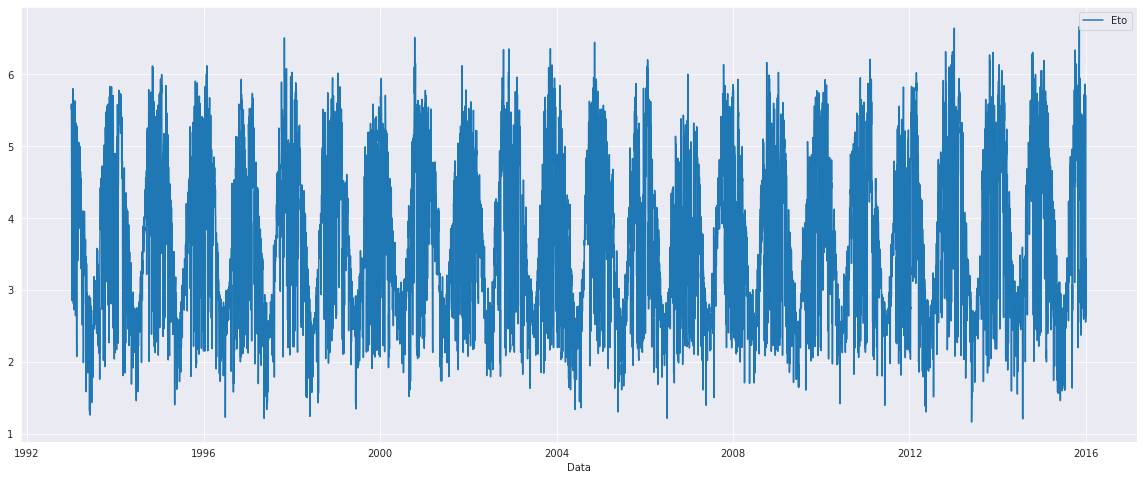

In [ ]:
ts=df[['Eto']]
print(type(ts))
ts.plot(figsize=(20,8))

In [ ]:
ts.describe()

Eto
count  8400.000000
mean      3.651051
std       1.113874
min       1.167139
25%       2.707635
50%       3.477012
75%       4.533670
max       6.663748

In [ ]:
ts.iloc[np.argmax(ts),:]

Eto    6.663748
Name: 2015-11-07, dtype: float64

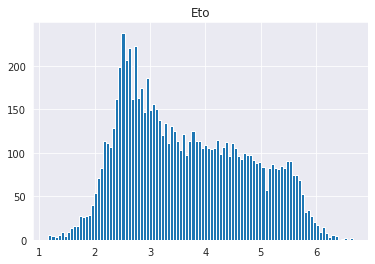

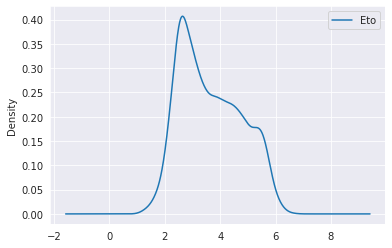

In [ ]:
ts.hist(bins=100)
ts.plot(kind='kde');

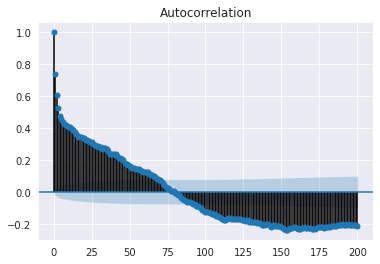

In [ ]:
# Quick check
plot_acf(ts, lags=200);

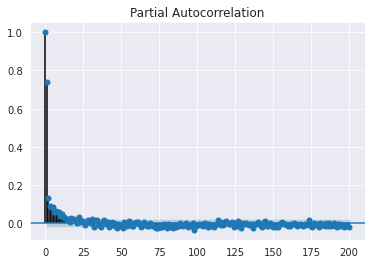

In [ ]:
plot_pacf(ts, lags=200);

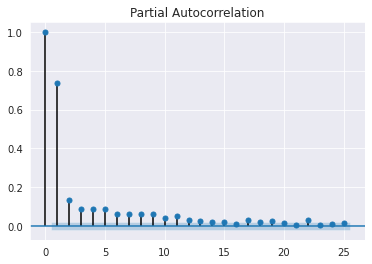

In [ ]:
plot_pacf(ts, lags=25);

## Set the frequency

In [ ]:
tsf=ts.asfreq('D');
#tsf=tsf.dropna()

tsf[tsf.isnull().any(axis=1)];

tsf.ffill(inplace=True);
display(tsf.head(15));
tsf.index       

Eto
Data                
1993-01-01  5.515947
1993-01-02  5.587673
1993-01-03  5.319605
1993-01-04  4.245526
1993-01-05  3.004685
1993-01-06  2.984026
1993-01-07  3.270312
1993-01-08  2.865333
1993-01-09  2.853518
1993-01-10  4.260885
1993-01-11  5.212823
1993-01-12  4.152197
1993-01-13  5.802051
1993-01-14  5.668575
1993-01-15  5.477057

DatetimeIndex(['1993-01-01', '1993-01-02', '1993-01-03', '1993-01-04',
               '1993-01-05', '1993-01-06', '1993-01-07', '1993-01-08',
               '1993-01-09', '1993-01-10',
               ...
               '2015-12-22', '2015-12-23', '2015-12-24', '2015-12-25',
               '2015-12-26', '2015-12-27', '2015-12-28', '2015-12-29',
               '2015-12-30', '2015-12-31'],
              dtype='datetime64[ns]', name='Data', length=8400, freq='D')

## Define the First difference: $X_t - X_{t-1}$

In [ ]:
# Is it a random walk?
diff=df[['Diff']]
diff.plot()

KeyError: ignored

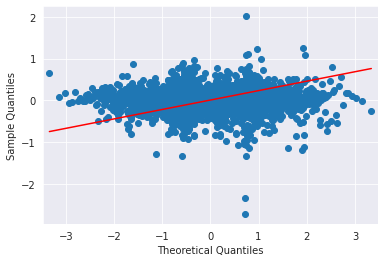

In [ ]:
sm.qqplot(diff, line='q');

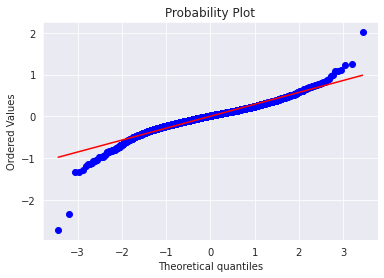

In [ ]:
plt.figure('QQ plot');
stats.probplot(diff['Diff'], plot=plt);


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


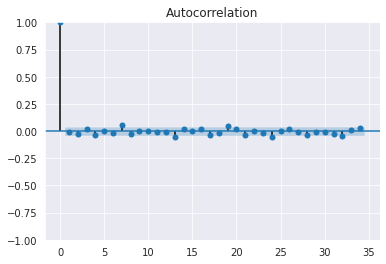

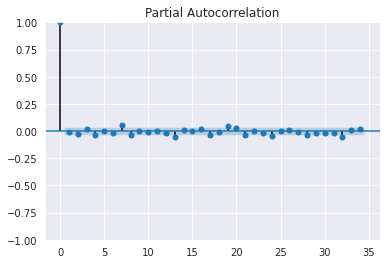

In [ ]:
plot_acf(diff)
plot_pacf(diff);

# I. Analysis of the time-series

## Seasonal decomposition (with the frequency set)

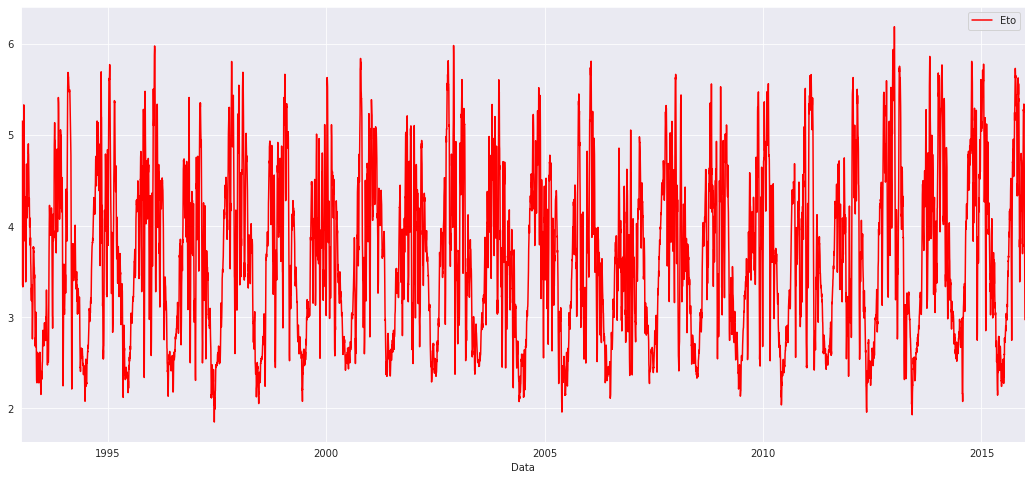

In [ ]:
ts_dec=seasonal_decompose(tsf,  extrapolate_trend = 'freq')
ts_dec.trend.plot(color='r');
plt.show()


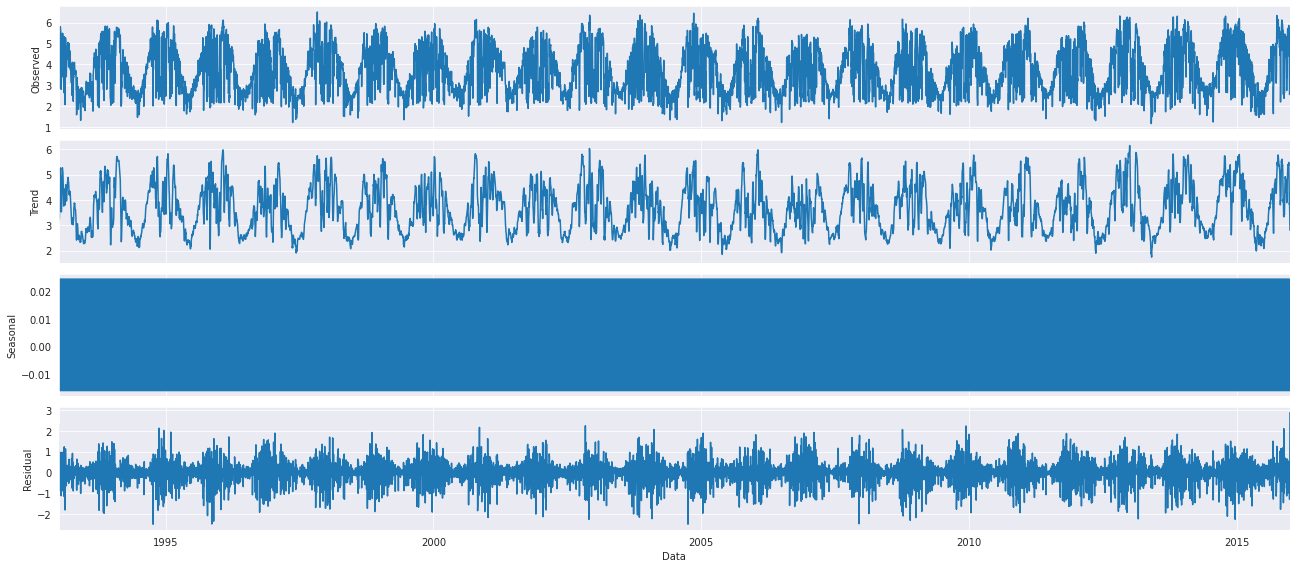

In [ ]:
pylab.rcParams['figure.figsize'] = (18, 8)
ts_dec.plot();


## FFT: Denoise the signal/time-series 

Apply Fast-Fourier Transform to denoise the time-series (just for the heck of it).


In [ ]:
tstrend=pd.DataFrame(ts_dec.trend)
tstrend

Eto
Data                
1993-01-01  3.166259
1993-01-04  3.299844
1993-01-05  3.804099
1993-01-06  3.273976
1993-01-07  3.467436
...              ...
2015-12-25  4.474821
2015-12-28  3.829245
2015-12-29  3.870271
2015-12-30  3.214412
2015-12-31  2.807576

[6000 rows x 1 columns]

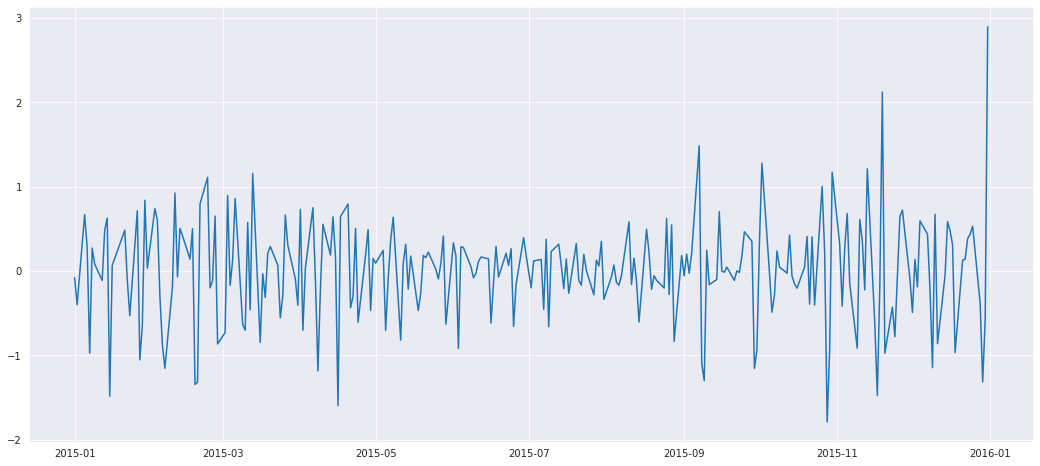

In [ ]:
ts_rest=tsf['Eto']-tstrend['Eto']
ts_rest=ts_rest['2015':]
plt.plot(ts_rest)
plt.show()

In [ ]:
ts_rest.isna().sum()

0

In [ ]:
'''
t=np.arange(0,len(ts_rest))
p=np.polyfit(t, ts_rest.values, 1)
ts_rest=ts_rest.values - p[0]*t -p[1]
plt.plot(ts_rest)
plt.show()
'''

'\nt=np.arange(0,len(ts_rest))\np=np.polyfit(t, ts_rest.values, 1)\nts_rest=ts_rest.values - p[0]*t -p[1]\nplt.plot(ts_rest)\nplt.show()\n'

In [ ]:
ts_rest.mean()

0.006978518580045077

In [ ]:
len(ts_rest)

261

In [ ]:
# SAMPLE_RATE determines how many data points the signal uses to represent the sine wave per second. 
# So if the signal had a sample rate of 10 Hz and was a five-second sine wave, then it would have 10 * 5 = 50 data points.

# N=sample_rate * duration
#set N (window length)
N=int(len(ts_rest)    )
sample_rate=500 # Hertz=cycles per second (frequecy)

#set d (sample spacing) = inverse of the sampling rate
d=1/sample_rate

duration=  N*d  #seconds
print('Duration is {} second(s)'.format(duration))

ts_fft=fft(ts_rest.values)
ts_freq=fftfreq(N,  d)  # Return the Discrete Fourier Transform sample frequencies (sample frequency POINTS)
# If the sample spacing 'd' is in seconds then the frequency is cycles per second.

Duration is 0.522 second(s)


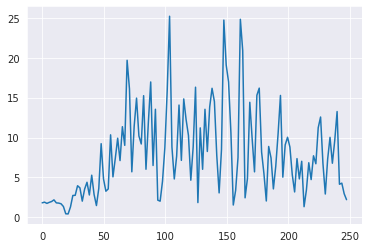

In [ ]:
plt.plot(ts_freq [:N//2] , np.abs(ts_fft[0:N//2]  ));
plt.show()

In [ ]:
sample_rate # 250-8000

500

In [ ]:
from scipy.io.wavfile import write

# Remember SAMPLE_RATE = 44100 Hz is our playback rate
write("mywave.wav", int(sample_rate), np.int16(ts_rest.values) )

The frequency spectrum that fft() outputted was reflected about the y-axis so that the negative half was a mirror of the positive half. This symmetry was caused by inputting real numbers (not complex numbers) to the transform.


The values returned by rfft() represent the power of each frequency bin. If you set the power of a given bin to zero, then the frequencies in that bin will no longer be present in the resulting time-domain signal.

Using the length of xf, the maximum frequency, and the fact that the frequency bins are evenly spaced, you can work out the target frequency’s index:

In [ ]:
target_freq=40
pts_per_freq=len(ts_freq)/ (sample_rate)
target_id=int(  pts_per_freq* target_freq)


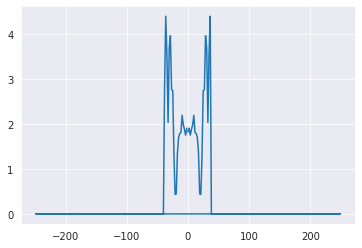

In [ ]:
ts_fft[target_id:-target_id]=0
#ts_fft[:N-target_freq:-1]=0
plt.plot(ts_freq,  np.abs(ts_fft));
plt.show()

In [ ]:
ts_ifft=ifft(ts_fft)

522


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


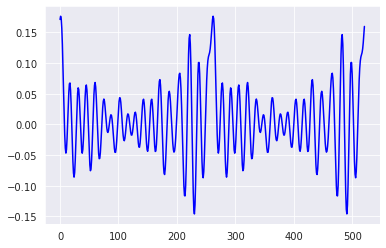

In [ ]:
#In case you want to do predictions extending the ifft
c=[*ts_ifft, *ts_ifft]
print( len(c) )
plt.plot( c, color='b',  label='IFFT' )
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


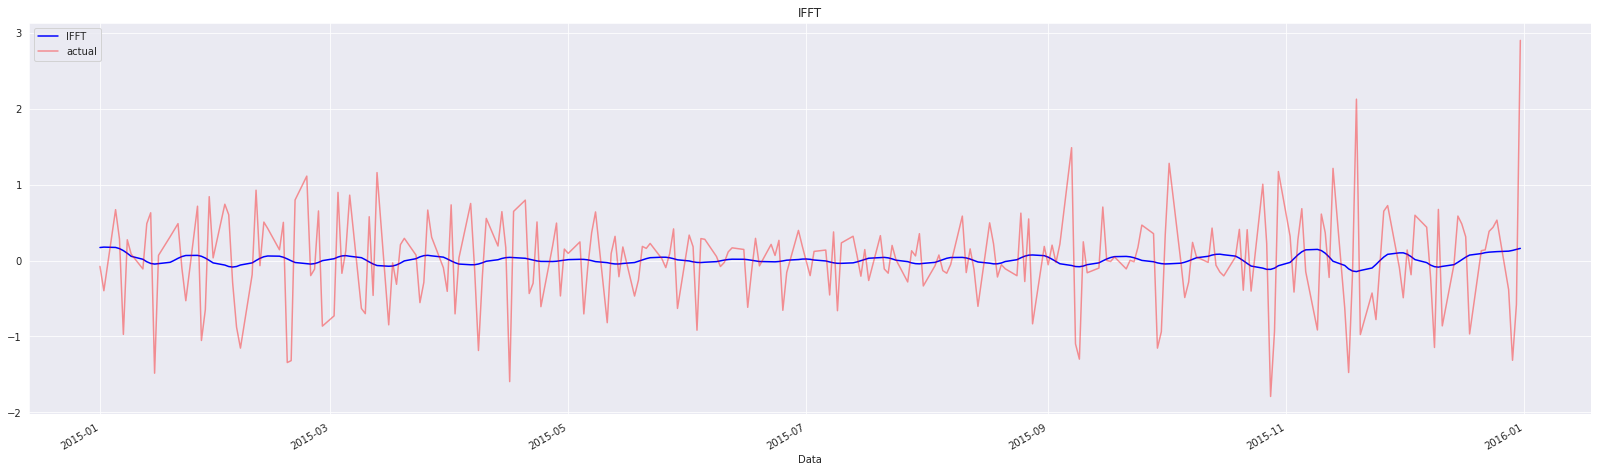

In [ ]:
plt.plot(ts_rest.index, ts_ifft, color='b',  label='IFFT' )
ts_rest.plot(color='r', figsize=(28,8), alpha=0.4,  label='actual')
plt.title('IFFT')
plt.legend(loc='best')
plt.show()


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


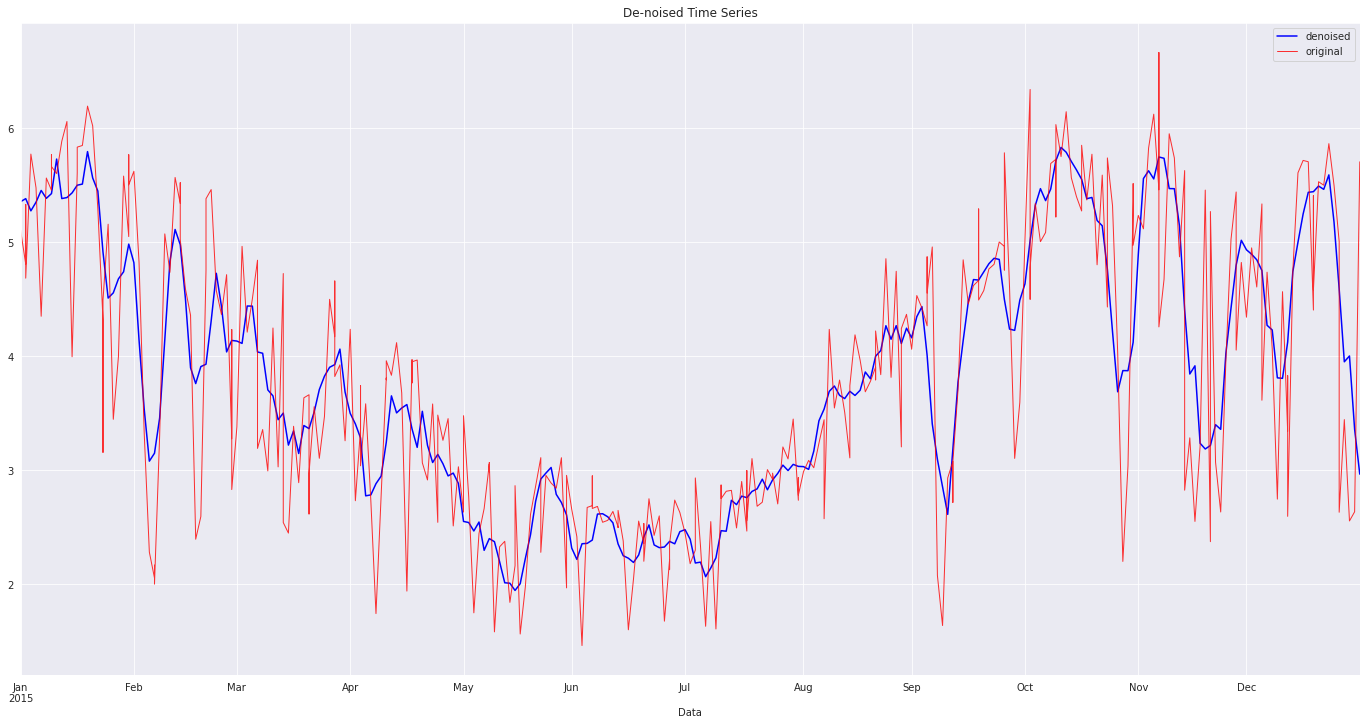

In [ ]:
a= ts_denoised=tstrend['Eto']['2015':]+ts_ifft
b= tsf['Eto']['2015':]
a.plot(color='b', label='denoised',  figsize=(24,12), animated=True)
b.plot(color='r',linestyle='-', lw=1,  alpha=0.8, label='original')
plt.title('De-noised Time Series')
plt.legend(loc='best')
plt.show()

## Simple Moving Average (SMA)

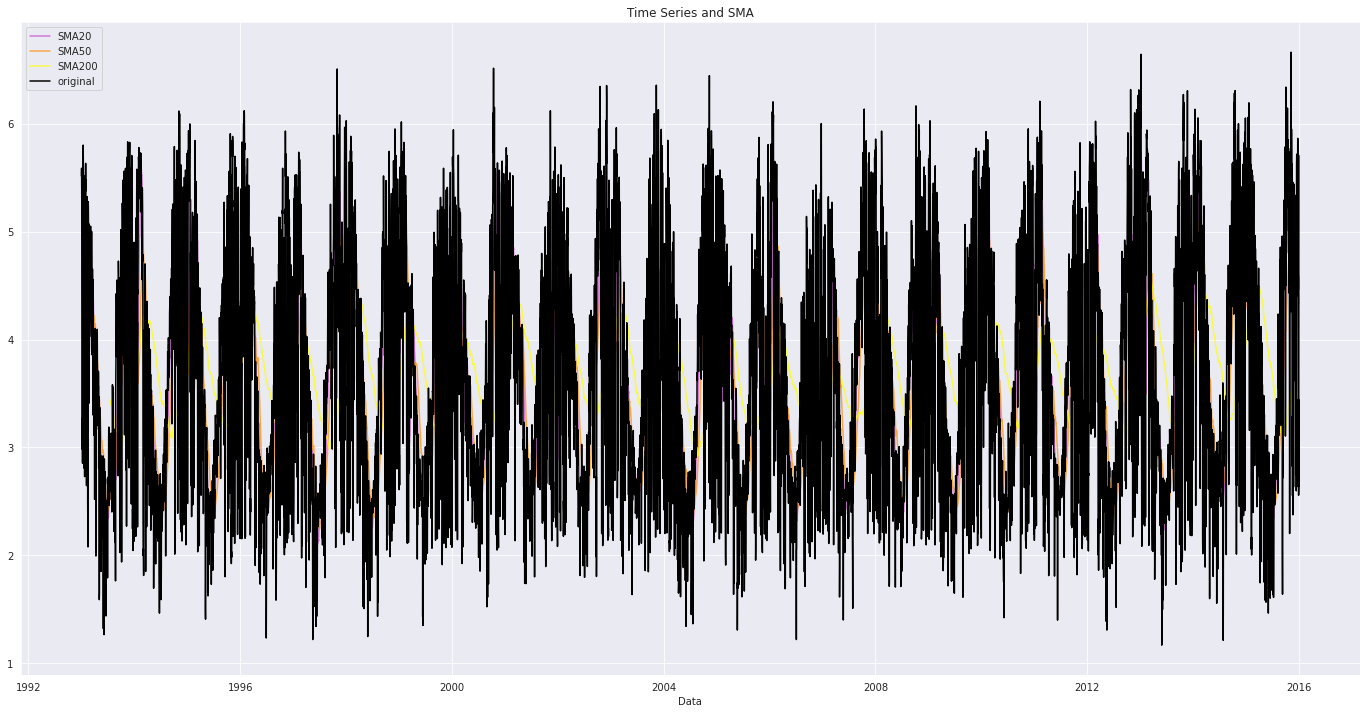

In [ ]:
sma={}
for k in [20, 50, 200]:
    sma[k]=ts.rolling(k).mean()

plt.figure()
sma[20]['Eto'].plot(color='m', label='SMA20',  figsize=(24,12),alpha=0.5,  animated=True)
sma[50]['Eto'].plot(color='darkorange', label='SMA50', alpha=0.7,  animated=True)
sma[200]['Eto'].plot(color='yellow', label='SMA200',alpha=0.7,    animated=True)
ts['Eto'].plot(color='black',   alpha=1, label='original')
plt.title('Time Series and SMA')
plt.legend(loc='best')
plt.show()

## Stationarity: quick check

In [ ]:
result = adfuller(ts['Eto'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -9.475015
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [ ]:
result = adfuller(diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

NameError: ignored

The time-series $X_t$ and the difference time series $X_t - X_{t-1}$ are stationary (no unit root is present).

## ARIMA



**Use auto_arima to find the optimal hyperparameters p,d,q**

In [ ]:
results={}

In [ ]:
model = pm.auto_arima(ts, start_p=1, start_q=1, 
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                   #   d=0,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                  #    D=0, 
                  #    information_criterion='aic', # default, (‘aic’, ‘bic’, ‘hqic’, ‘oob’
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=19370.694, Time=1.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=46343.897, Time=0.12 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=20151.384, Time=0.22 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=37373.620, Time=0.48 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=18594.394, Time=2.10 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=19663.244, Time=0.26 sec


KeyboardInterrupt: ignored

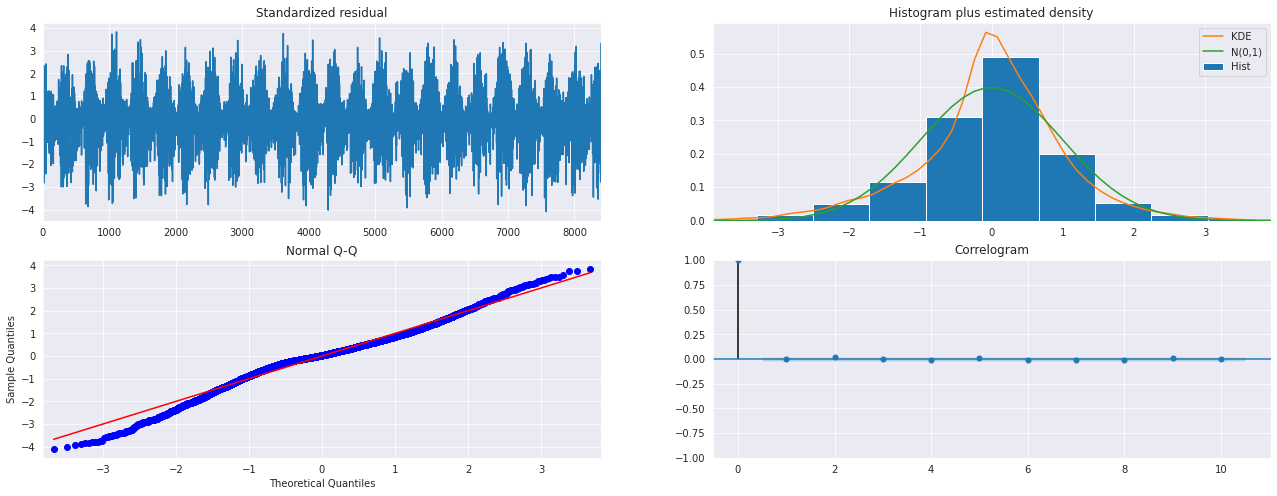

In [ ]:
model.plot_diagnostics(figsize=(22,8))
plt.show()

**Remark**: Essentially, we have that $X_t=X_{t-1}+\epsilon_t$ where $\epsilon_t \sim N(0, \sigma^2)$ with $\sigma^2=$sigma2.

In [ ]:
# Try it, fit model
model_1 =  sm.tsa.statespace.SARIMAX(ts, order=(0,1,0))
model_fit = model_1.fit(return_params=0)
# summary of fit model
print(model_fit.summary())

                           Statespace Model Results                           
Dep. Variable:                    Eto   No. Observations:                 8400
Model:               SARIMAX(0, 1, 0)   Log Likelihood              -10117.560
Date:                Sun, 12 Jun 2022   AIC                          20237.121
Time:                        16:19:33   BIC                          20244.156
Sample:                    01-01-1993   HQIC                         20239.523
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.6514      0.007     92.717      0.000       0.638       0.665
Ljung-Box (Q):                      700.55   Jarque-Bera (JB):              1555.03
Prob(Q):                              0.00   Pr

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  periods=len(index) + 1,


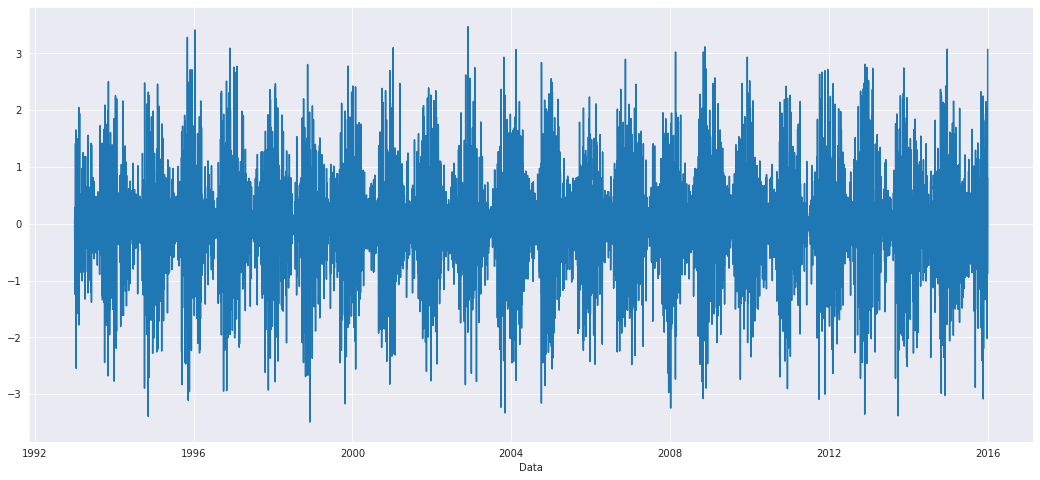

In [ ]:
residuals= model_fit.resid[1:]
plt.figure()

residuals.plot();

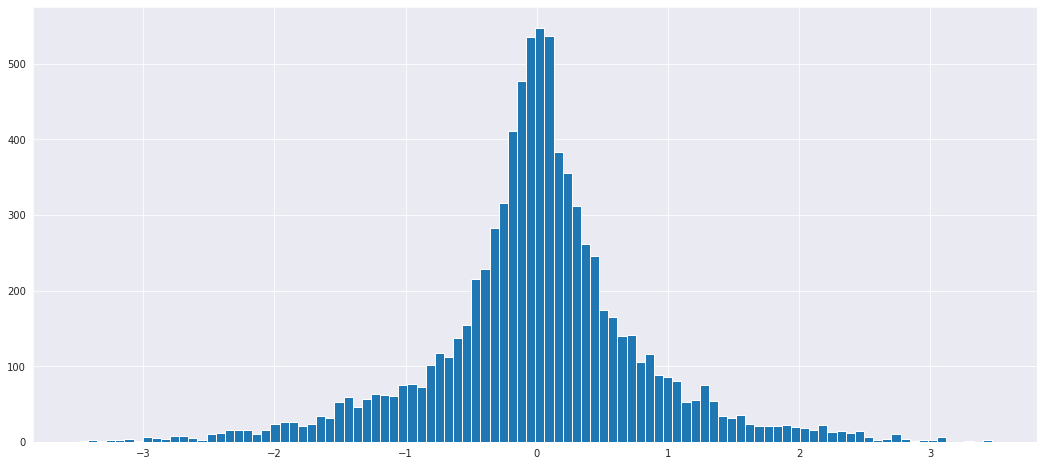

In [ ]:
plt.figure()
residuals.hist(bins=100);

In [ ]:
residuals.describe()

count    8399.000000
mean        0.000023
std         0.807135
min        -3.489872
25%        -0.340375
50%         0.009206
75%         0.366813
max         3.467317
dtype: float64

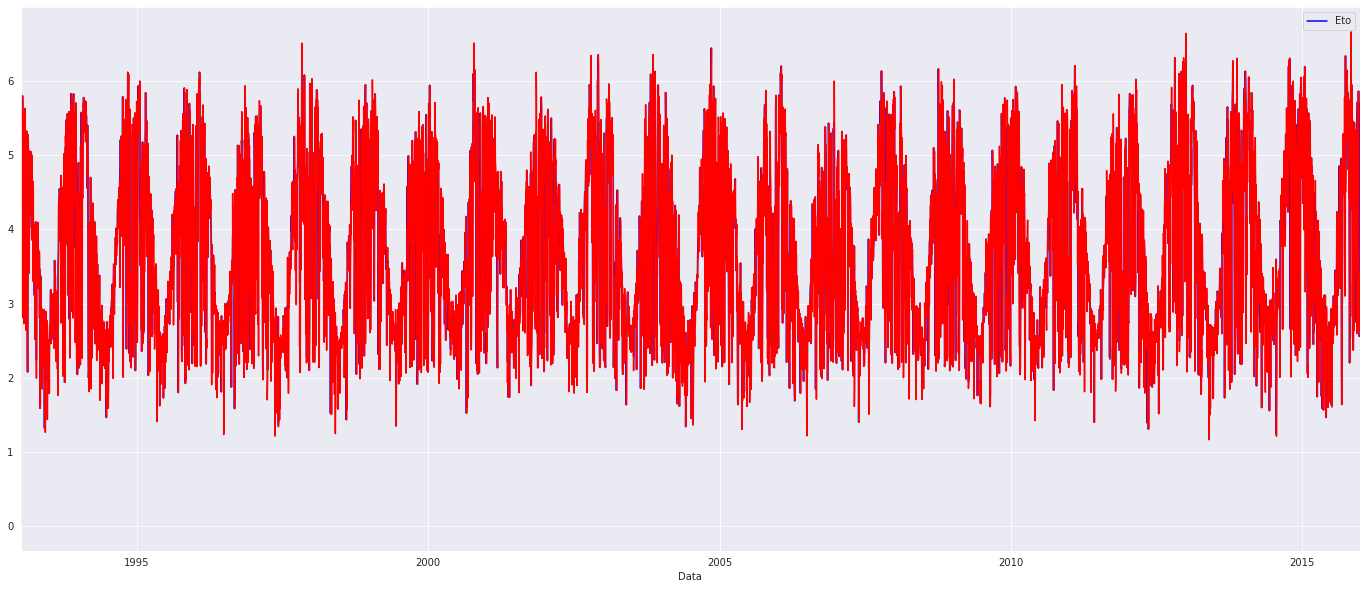

In [ ]:
# Actual vs Fitted
tsf.plot(color='b', label='actual');
model_fit.predict().plot(figsize=(24,10), color='r', label='ARIMA')
plt.show()

TypeError: ignored

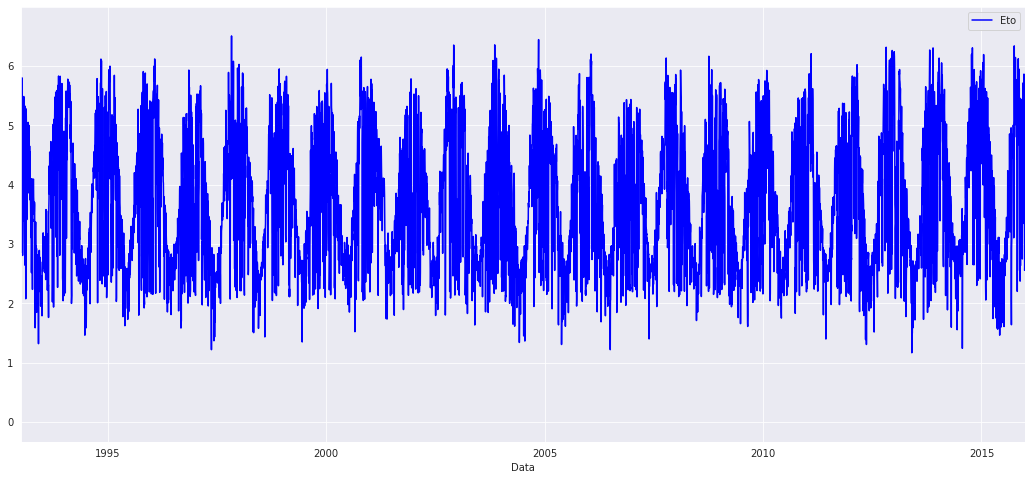

In [ ]:
# Alternative way to plot them

tsf.plot(color='b', label='actual');
model_fit.fittedvalues.plot(color='r');
plt.show();

**MSE and MAE**

In [ ]:
# evaluate forecasts
mse = (mean_squared_error(ts, model_fit.predict()  ))
print('Test MSE: %.3f' % mse)

mae = (mean_absolute_error(ts, model_fit.predict()  ))
print('Test MAE: %.3f' % mae)

Test MSE: 0.655
Test MAE: 0.559


## ARIMA for log returns, $\log X_t$

In [ ]:
logts=df[['LogClose']];
logts.plot();
logts.hist(bins=100);

KeyError: ignored

In [ ]:
logts.describe()

NameError: ignored

In [ ]:
logtsf=logts.asfreq('b');

logtsf[logtsf.isnull().any(axis=1)];

logtsf.ffill(inplace=True);
display(logtsf.head(15));
logtsf.index        #ts.unstack().values

#pd.Series(ts.unstack().values)

LogClose
Date                
2013-01-02  3.333097
2013-01-03  3.335592
2013-01-04  3.341801
2013-01-07  3.339676
2013-01-08  3.338258
2013-01-09  3.345685
2013-01-10  3.345508
2013-01-11  3.347621
2013-01-14  3.347797
2013-01-15  3.346917
2013-01-16  3.346389
2013-01-17  3.350606
2013-01-18  3.356026
2013-01-21  3.358638
2013-01-22  3.359333

DatetimeIndex(['2013-01-02', '2013-01-03', '2013-01-04', '2013-01-07',
               '2013-01-08', '2013-01-09', '2013-01-10', '2013-01-11',
               '2013-01-14', '2013-01-15',
               ...
               '2022-05-19', '2022-05-20', '2022-05-23', '2022-05-24',
               '2022-05-25', '2022-05-26', '2022-05-27', '2022-05-30',
               '2022-05-31', '2022-06-01'],
              dtype='datetime64[ns]', name='Date', length=2456, freq='B')

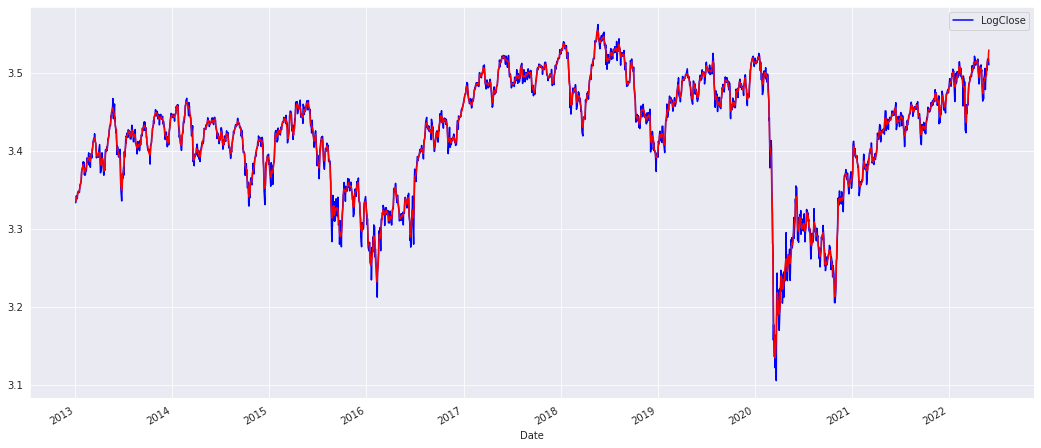

In [ ]:
logts_dec=seasonal_decompose(logtsf,  extrapolate_trend = 'freq')

logts.plot(color='b');
logts_dec.trend.plot(color='r');
plt.show()


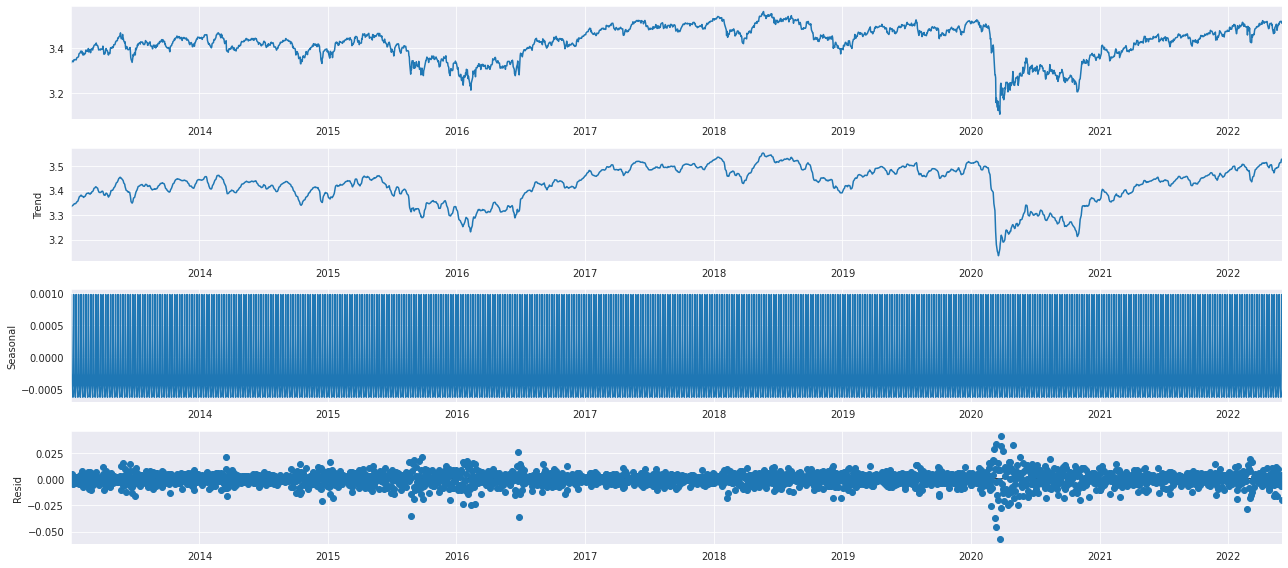

In [ ]:
logts_dec.plot();

### Difference of the logs

LogDiff
count  2381.000000
mean      0.000084
std       0.010193
min      -0.109522
25%      -0.004705
50%       0.000527
75%       0.005150
max       0.086470

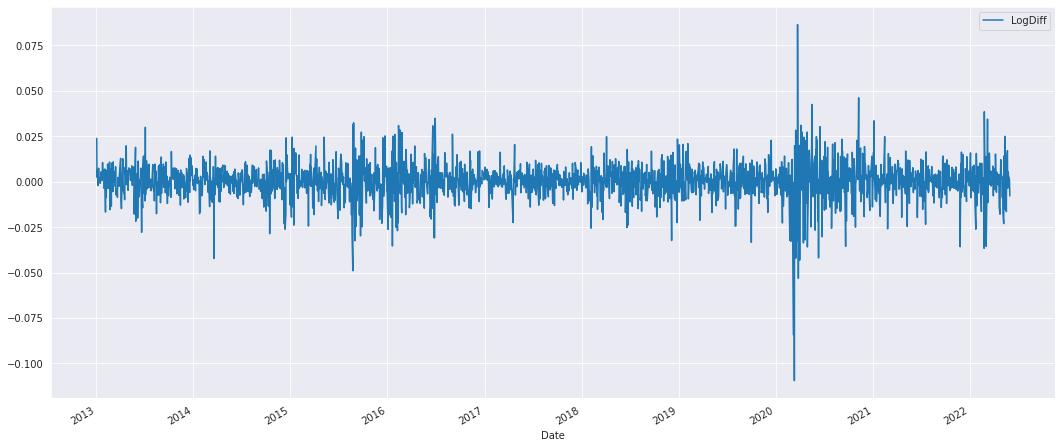

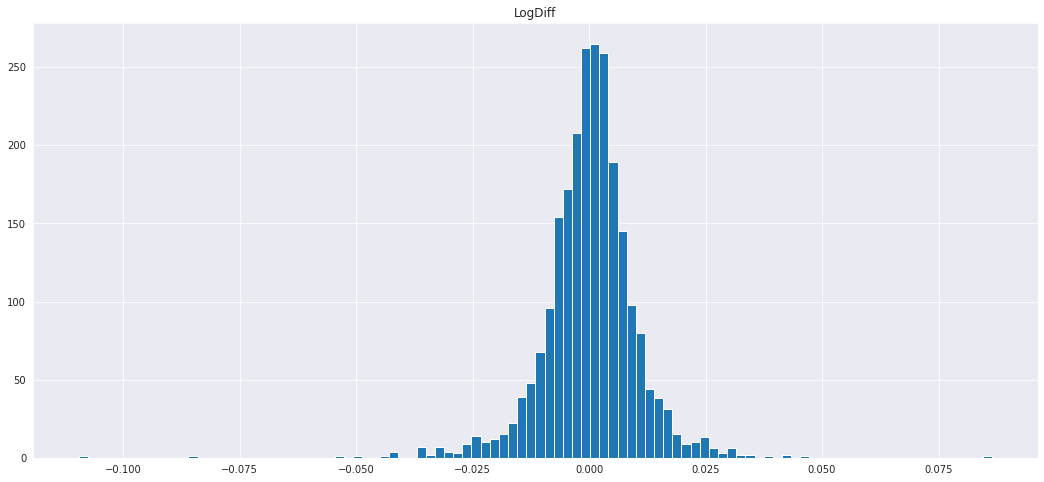

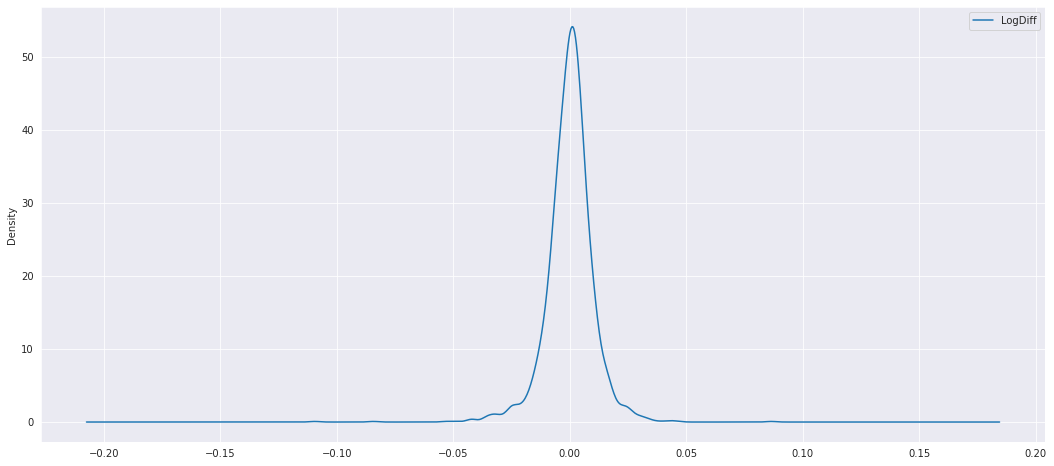

In [ ]:
# This is the difference of the logs, i.e. the r's

logdiff=df[['LogDiff']];
logdiff.plot()
logdiff.hist(bins=100);
logdiff.plot(kind='kde')
logdiff.describe()

In [ ]:
result = adfuller(logdiff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.083518
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


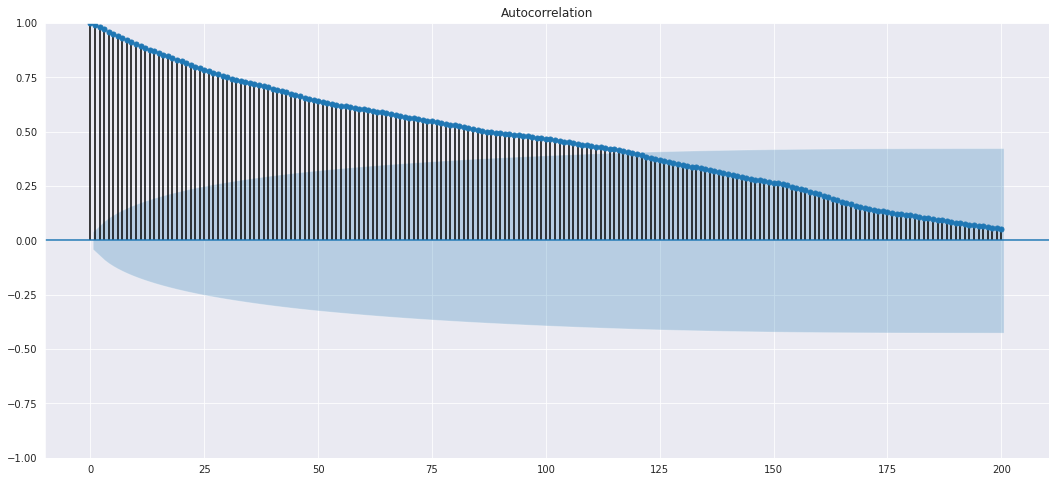

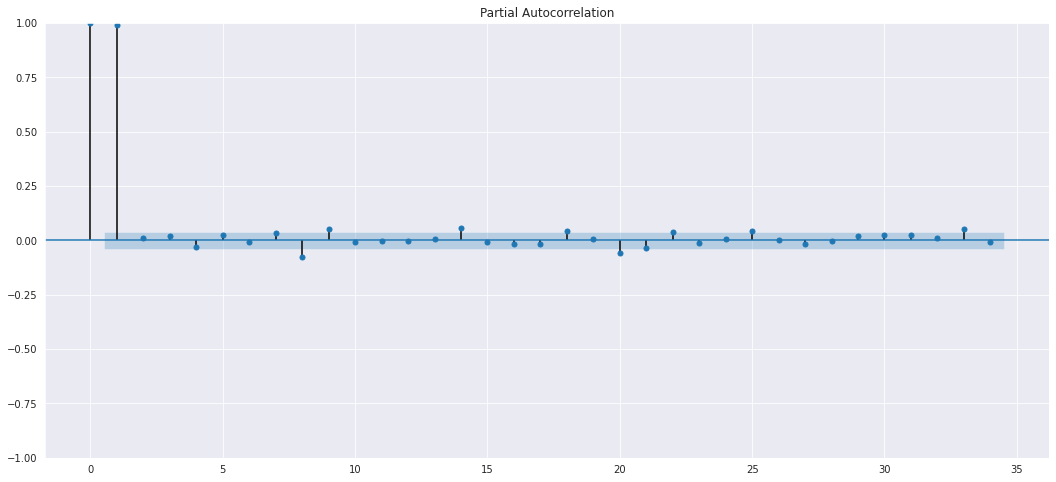

In [ ]:
plot_acf(logts, lags=200)
plot_pacf(logts);

**Apply auto_arima to the log returns**

In [ ]:
model_ld = pm.auto_arima(logts, start_p=1, start_q=1, 
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                      m=1,              # frequency of series
                      #d=1,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      #D=0, 
                      information_criterion='aic', # default, (‘aic’, ‘bic’, ‘hqic’, ‘oob’
                     # trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_ld.summary())

NameError: ignored

 **This means that  $\log X_t - \log X_{t-1} = \epsilon_t, \text{where  } \epsilon_t \sim  \mathcal{N}(0, coef) $** 

In [ ]:
model_ld.plot_diagnostics(figsize=(22,8))
plt.show()

NameError: ignored

In [ ]:
# fit model

#model_ld_1 = model_ld  
model_ld_1 =  sm.tsa.statespace.SARIMAX(logts, order=(0,1,0))
model_fit_ld = model_ld_1.fit(  return_params=0)



NameError: ignored

In [ ]:
# summary of fit model
print(model_fit_ld.summary())

NameError: ignored

In [ ]:
model_fit_ld.predict()

NameError: ignored

**MSE and MAE**

In [ ]:
# evaluate forecasts
mse_ld = mean_squared_error(ts, np.exp( model_fit_ld.predict()  )  )
print('Test MSE: %.3f' % mse_ld)

mae_ld = mean_absolute_error(ts, np.exp( model_fit_ld.predict()  ))
print('Test MAE: %.3f' % mae_ld)

NameError: ignored

## GARCH

In [ ]:
am = arch_model(ts)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     37,   Neg. LLF: 4050.4061925777078
Iteration:     10,   Func. Count:     72,   Neg. LLF: 3932.4463028639743
Iteration:     15,   Func. Count:    106,   Neg. LLF: 3910.732037848239
Iteration:     20,   Func. Count:    137,   Neg. LLF: 3904.408752872677
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 3904.339309336762
            Iterations: 24
            Function evaluations: 162
            Gradient evaluations: 24
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -3904.34
Distribution:                  Normal   AIC:                           7816.68
Method:            Maximum Likelihood   BIC:                           7839.78
                         

This is $GARCH(1,1):$

$$  r_t = \mu+ e_t$$

$$\sigma_t^2 = \omega + \alpha_1 \epsilon_{t-1}^2 + \beta_1 \sigma_{t-1}^2$$

$$\epsilon_t = \sigma_t e_t,\;\; e_t \sim N(0,1) $$

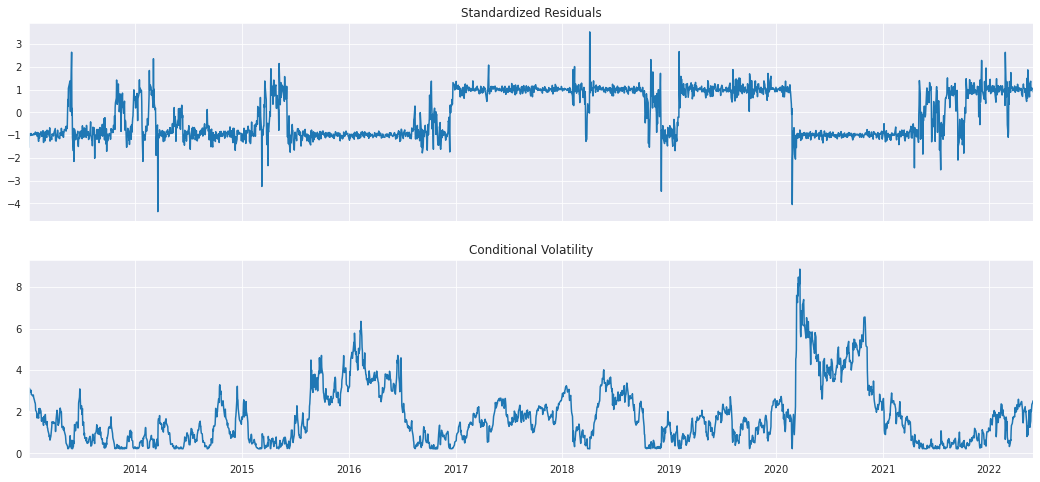

In [ ]:
garcgfig=res.plot()

# II. Forecasting and Backtesting

## Split the dataset: Train/test set  

In [ ]:
# split into train and test sets

split='2011'

ts_recent= (tsf['1993':'2012'])
ts_train=ts_recent[:split]
ts_test=ts_recent[ts_train.index[-1]+timedelta(days=1):'2012']
ts_test

Eto
Data                
2012-01-01  2.343399
2012-01-02  2.140238
2012-01-03  3.932297
2012-01-04  4.138469
2012-01-05  4.832823
...              ...
2012-12-27  5.330704
2012-12-28  5.224706
2012-12-29  3.295106
2012-12-30  5.815531
2012-12-31  6.165882

[366 rows x 1 columns]

## Naive Forecasting (our baseline)

In [ ]:
diff['2015-1':]

NameError: ignored

In [ ]:
mae=diff['2022-2':].abs().mean()
mae=mae['Diff']
mae

NameError: ignored

In [ ]:
mse=diff['2022-2':].pow(2).mean()
mse=mse['Diff']
mse

0.15061626999461927

In [ ]:
results['Naive* (daily updated)']=[mae, mse]

**Our Baseline**: Forecasting the whole 4-month period at once

In [ ]:
naive_error=ts_test-ts_train['Eto'][-1]
naive_mae=naive_error.abs().mean()
naive_mse=naive_error.pow(2).mean()
results['Naive (Baseline)']=[float(naive_mae), float(naive_mse)]

# ARIMA predictions


In [ ]:
model_tt = pm.auto_arima(ts_train, start_p=0, start_q=0, 
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=4, max_q=4, # maximum p and q
                     # m=1,              # frequency of series
                      #d=1,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      #start_P=0, 
                      #D=0, 
                      information_criterion='aic', # default, (‘aic’, ‘bic’, ‘hqic’, ‘oob’
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model_tt.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=4188.638, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3306.372, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3666.251, Time=0.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7395.407, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3263.422, Time=0.28 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=3244.821, Time=0.44 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=3214.294, Time=0.50 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=3181.438, Time=2.53 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3181.985, Time=1.96 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=3183.153, Time=2.59 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=3184.072, Time=1.38 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=3199.023, Time=0.67 sec

Best model:  ARIMA(4,0,1)(0,0,0)[0] intercept
Total fit time: 10.765 seconds
                           Statespace Model Results                           
Dep. Var

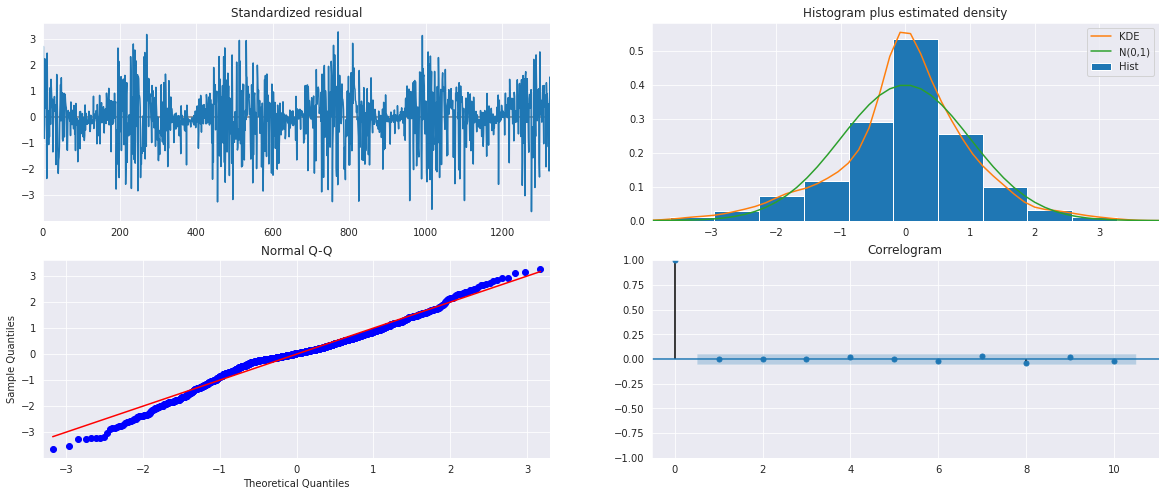

In [ ]:
model_tt.plot_diagnostics(figsize=(20,8))
plt.show()

In [ ]:
# fit model
model_tt_1 =  sm.tsa.statespace.SARIMAX(ts_train,order=(1,1,1) # order=(0,1,0) 
                                        #, seasonal_order=(4,1,2,5)
                                        )
model_tt_fit = model_tt_1.fit( return_params=0, disp=-1)
# summary of fit model
print(model_tt_fit.summary())

                           Statespace Model Results                           
Dep. Variable:                    Eto   No. Observations:                 1326
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1591.328
Date:                Sun, 12 Jun 2022   AIC                           3188.656
Time:                        16:25:10   BIC                           3204.224
Sample:                    01-01-2010   HQIC                          3194.492
                         - 01-30-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3712      0.028     13.133      0.000       0.316       0.427
ma.L1         -0.8676      0.018    -47.387      0.000      -0.903      -0.832
sigma2         0.6463      0.021     30.112      0.0

In [ ]:
#fc=model_tt_fit.predict( start=ts_train.index[-1]+ timedelta(days=1) , end=ts_test.index[-1] , alpha=0.05)
fc=model_tt_fit.predict( start=ts_test.index[0], end=ts_test.index[-1] , dynamic=True, alpha=0.05)

#fc=model_tt_fit.forecast( len(ts_test) )

#Forecast=model_tt_fit.predict(start=len(ts_train), 
                           # end=len(ts_train)+len(ts_test)-1, dynamic=True)
fc.head()

KeyError: ignored

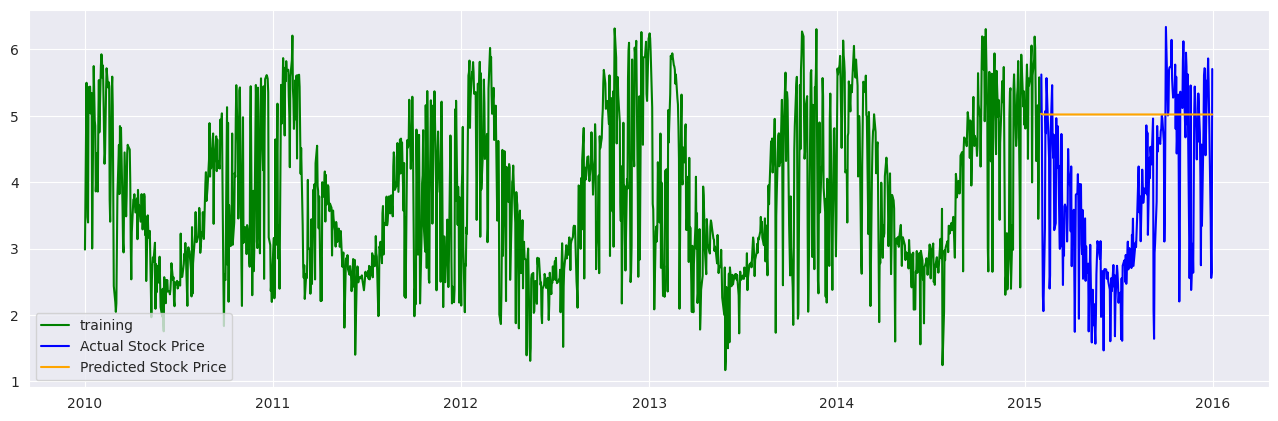

In [ ]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot( (ts_train), color='green', label='training')
plt.plot( (ts_test), color = 'blue', label='Actual Stock Price')
plt.plot( fc, color = 'orange',label='Predicted Stock Price')
plt.legend(loc='best')

plt.show()

**MSE and MAE**

In [ ]:
# report performance
mse = mean_squared_error(ts_test, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(ts_test, fc)
print('MAE: '+str(mae))
rmse = np.sqrt(mean_squared_error(ts_test, fc))
print('RMSE: '+str(rmse))

results['ARIMA(1,1,1)']=[mae, mse]

MSE: 3.179423094713832
MAE: 1.4965877013590174
RMSE: 1.7830936864656979


# Triple Exponential Smoothing

In [ ]:
triple_xs=ExponentialSmoothing(ts_train,  seasonal_periods=5 ,trend='add' , seasonal='mul'
                               ,use_boxcox=True
                               ,initialization_method="estimated"
                              ).fit(optimized=True)

triple_xs.params

TypeError: ignored

In [ ]:
fc_xs=triple_xs.predict( start=ts_test.index[0], end=ts_test.index[-1])

NameError: ignored

NameError: ignored

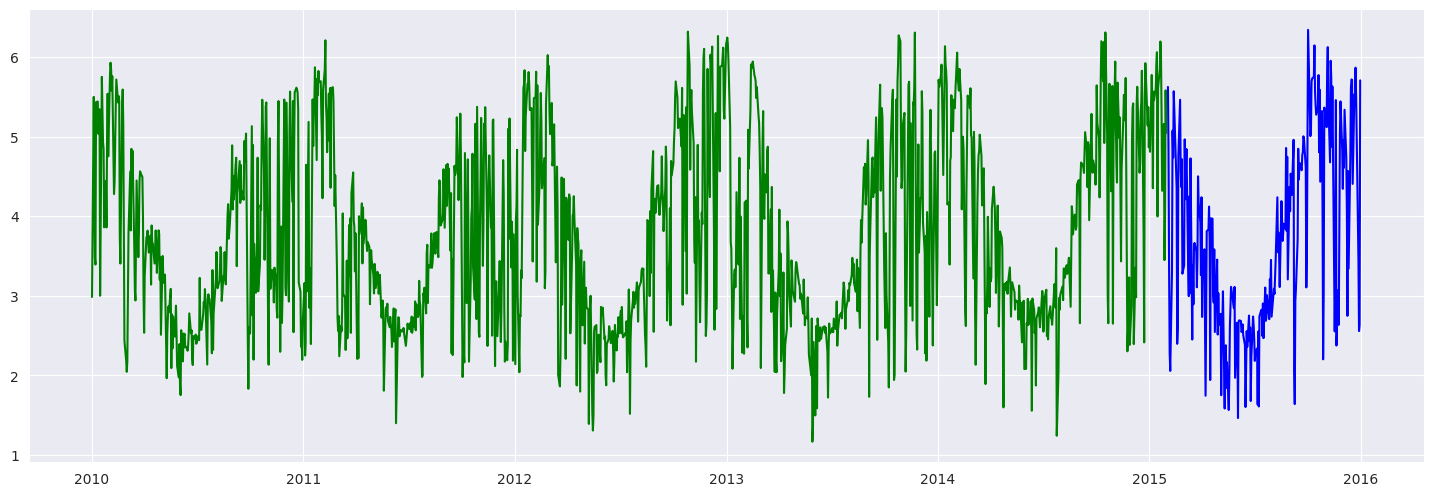

In [ ]:
plt.figure(figsize=(18,6), dpi=100)
plt.plot( (ts_train), color='green', label='training')
plt.plot( (ts_test), color = 'blue', label='Actual Stock Price')
plt.plot( fc_xs, color = 'orange',label='Predicted Stock Price')
plt.title('Exp smoothing')
plt.legend(loc='best')
plt.show()

In [ ]:
simulations=triple_xs.simulate(len(ts_test), repetitions=300, error='mul',  random_errors='bootstrap')

company='ETF'

ax=ts_train.plot(figsize=(24,8), color='blue', label='actual price',
               title="Forecasts and simulations from Holt-Winters' method" , legend=True)

ax.set_ylabel("Stock Price for {}".format(company))
ax.set_xlabel("Year")




simulations.plot(ax=ax, style='-', alpha=0.05, color='grey', label='simulations', legend=False)



fc_xs.plot(ax=ax, style='--',  color='red', label='forecasting',  legend=0)

#triple_xs.fittedvalues.plot(ax=ax,  color='blue')
ts_test.plot(ax=ax, color='black', label='actual', legend=0)
#plt.legend(loc='best')
plt.show()

NameError: ignored

**MSE and MAE**

In [ ]:
# report performance
mse = mean_squared_error(ts_test, fc_xs)
print('MSE: '+str(mse))
mae = mean_absolute_error(ts_test, fc_xs)
print('MAE: '+str(mae))
rmse = np.sqrt(mean_squared_error(ts_test, fc_xs))
print('RMSE: '+str(rmse))

results['Triple Exponential Smoothing']=[mae, mse]

MSE: 0.8943612538282855
MAE: 0.7192489843644996
RMSE: 0.9457067483254444


# Moving Average plus Smooth Past

* Moving Average forecast: Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast.

* This is a good option *if the time-series exhibits seasonality*: consider the sum of the moving average of the difference $X_t - X_{t-period}$, and the value 1 period ago.

# Monte Carlo Simulations

We just use the log-normal distribution (another -perhaps better- option is geometric Brownian motion).

In [ ]:
def MCsim(S, T, mu, vol, Np):
    dt=1/T
    price_df=pd.DataFrame(index=range(T+1), columns=range(1,Np+1) )
    for i in range(Np):
        daily_returns=np.random.normal(mu,vol,T)
        price_list = [0]
        for r in daily_returns:
            price_list.append(price_list[-1]+r)
        price_df.iloc[:,i]=S*np.exp(price_list)
    display(price_df.head())
    price_df.iloc[:,:10].plot(figsize=(14,6))
    return price_df
    #price_df[:5,].plot()

In [ ]:
logdiff

LogDiff
Date                
2013-01-02  0.023832
2013-01-03  0.002495
2013-01-04  0.006210
2013-01-07 -0.002125
2013-01-08 -0.001419
...              ...
2022-05-26  0.005380
2022-05-27  0.003125
2022-05-30  0.001930
2022-05-31 -0.000297
2022-06-01 -0.007892

[2381 rows x 1 columns]

In [ ]:
logdiff.iloc[:-len(ts_test),:].describe()

LogDiff
count  2294.000000
mean      0.000078
std       0.010121
min      -0.109522
25%      -0.004701
50%       0.000489
75%       0.005108
max       0.086470

In [ ]:
mu=0.000078 # you can just take the train, better
vol=0.010121

S=ts_train.values[-1]

T = len(ts_test) 
Np=10000 

1          2          3          4          5          6      \
0  32.709999  32.709999  32.709999  32.709999  32.709999  32.709999   
1  32.714769  32.213341  32.637975  32.967812  32.901907  32.801059   
2  33.261852  31.982472  32.761587  33.312194  32.418987  32.820178   
3  33.399782  32.051516  32.808961  33.021654  32.705202  32.860860   
4  33.047367  31.930422  32.695245  33.130129  32.868785  33.049678   

       7          8          9          10     ...      9991       9992   \
0  32.709999  32.709999  32.709999  32.709999  ...  32.709999  32.709999   
1  32.672238  32.813569  32.904419  32.772748  ...  33.523793  32.007822   
2  32.767068  32.511997  32.509341  33.434450  ...  33.559203  32.284717   
3  32.580904  32.751998  32.210341  32.893453  ...  33.370243  32.207623   
4  32.948985  33.074031  32.522793  33.478042  ...  33.133306  32.373442   

       9993       9994       9995       9996       9997       9998   \
0  32.709999  32.709999  32.709999  32.709999  32.709999  32.709999   
1  32.773707  32.469921  32.212079  32.303817  32.844598  33.069075   
2  32.682280  32.035200  32.146304  32.494584  32.896095  33.225345   
3  32.575789  31.674555  31.777809  32.789213  33.266829  32.929600   
4  33.147202  31.839864  31.441056  32.400811  32.992108  33.086081   

       9999       10000  
0  32.709999  32.709999  
1  32.634096  32.336618  
2  32.192890  32.698272  
3  31.682950  33.089595  
4  31.436783  32.843035  

[5 rows x 10000 columns]

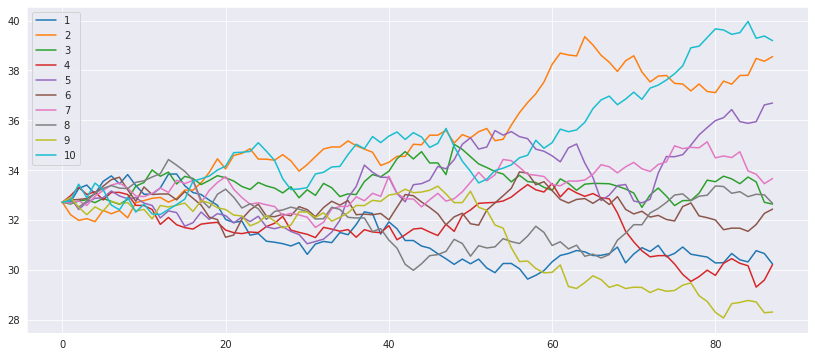

In [ ]:
allpaths_df= MCsim(S, T, mu, vol,  Np)

In [ ]:
allpaths_df['mean']=allpaths_df.mean(axis=1)

In [ ]:
mcfc=allpaths_df[['mean']][1:]

In [ ]:
mcfc.index=ts_test.index

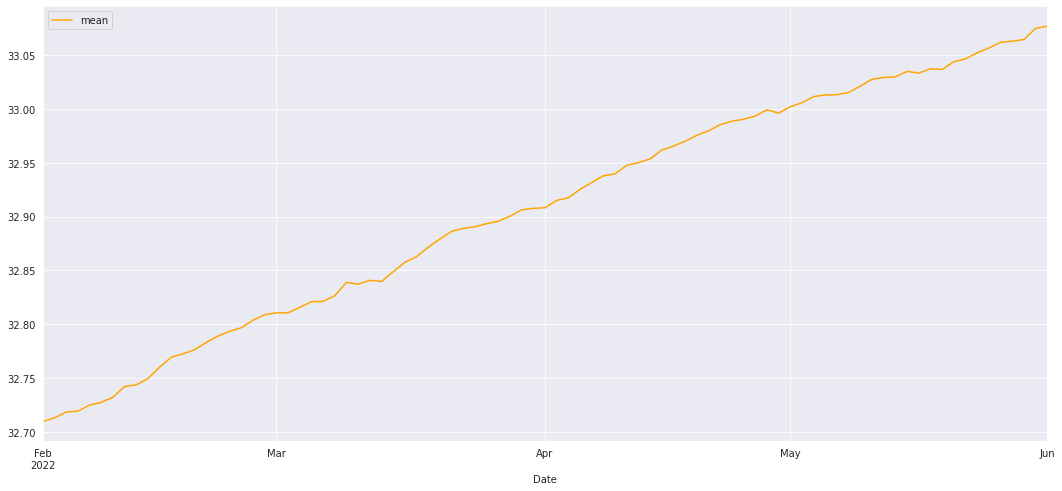

In [ ]:
mcfc.plot(color='orange')

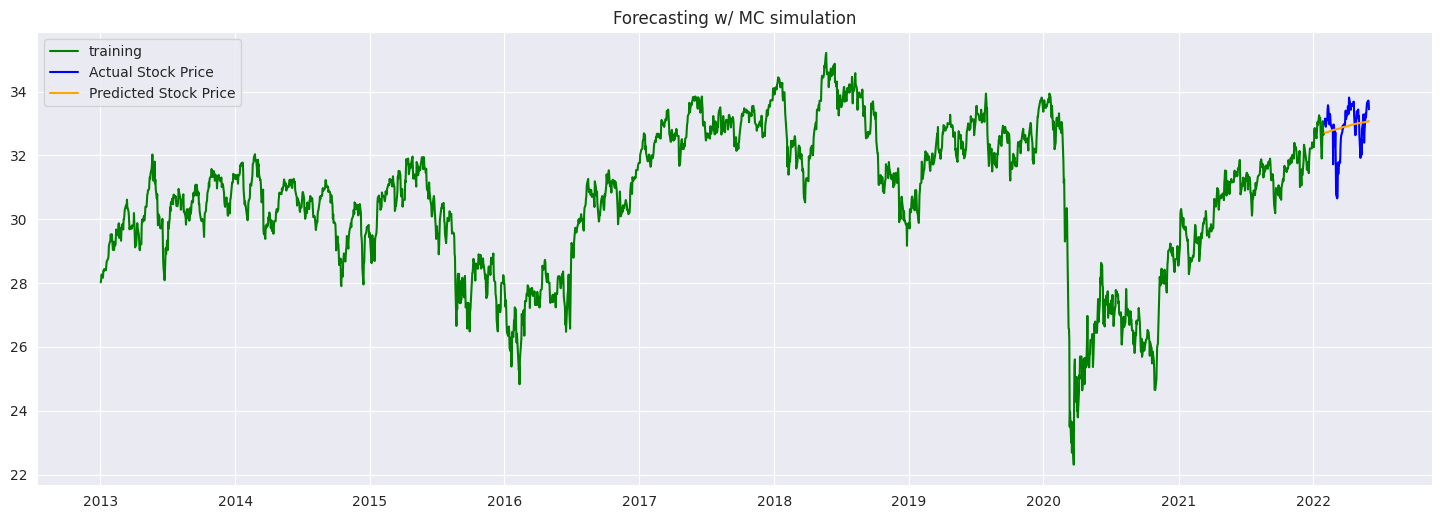

In [ ]:
plt.figure(figsize=(18,6), dpi=100)
plt.plot( (ts_train), color='green', label='training')
plt.plot( (ts_test), color = 'blue', label='Actual Stock Price')
plt.plot( mcfc, color = 'orange',label='Predicted Stock Price')
plt.title('Forecasting w/ MC simulation')
plt.legend(loc='best')
plt.show()

In [ ]:
# report performance
mse = mean_squared_error(ts_test, mcfc)
print('MSE: '+str(mse))
mae = mean_absolute_error(ts_test, mcfc)
print('MAE: '+str(mae))
rmse = np.sqrt(mean_squared_error(ts_test, mcfc))
print('RMSE: '+str(rmse))

results['Monte Carlo Simulations']=[mae, mse]

MSE: 0.445788718540071
MAE: 0.5078708246972398
RMSE: 0.6676741110302773


## Distribution of predictions for the last day

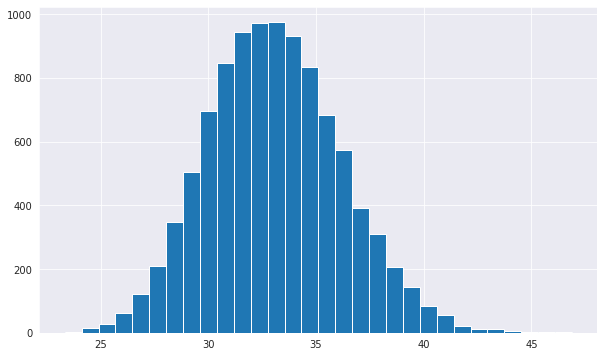

In [ ]:
allpaths_df.iloc[-1, 0:-1].hist(bins=30, figsize=(10,6))

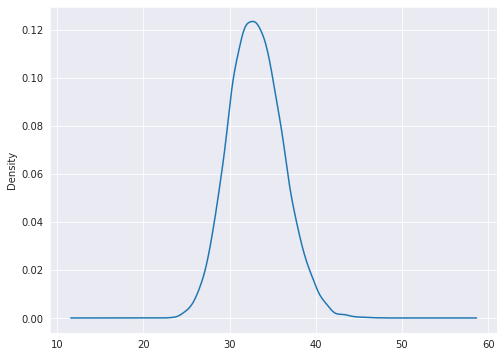

In [ ]:
allpaths_df.iloc[-1, 0:-1].plot(kind="kde", figsize=(8,6))

In [ ]:
# Mean
allpaths_df.iloc[-1, 0:-1].mean()

33.076832906118916

In [ ]:
# Sigma 
allpaths_df.iloc[-1, 0:-1].std()

3.1159190174100715

In [ ]:
# Actual Price
ts_test['Close'][-1]

33.44499969482422

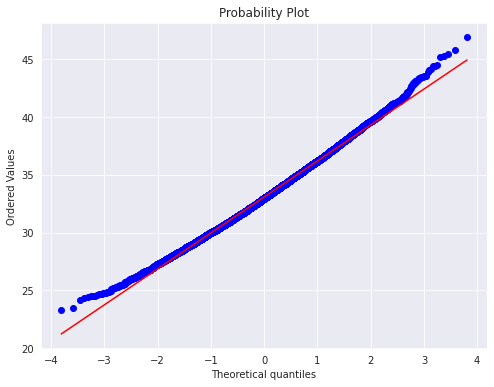

In [ ]:
plt.figure('QQ plot', figsize=(8,6));
stats.probplot(allpaths_df.iloc[-1, 0:-1], plot=plt);

# fbprophet

*Prophet is open source software released by Facebook's Core Data Science team.*

In [ ]:
#pip install fbprophet

In [ ]:
# check prophet version
import fbprophet
# print version number
print('Prophet %s' % fbprophet.__version__)

Prophet 0.7.1


In [ ]:
ts_train_fb=ts_train.reset_index()

ts_train_fb.columns=['ds', 'y']

ts_train_fb

ds          y
0    2013-01-02  28.025000
1    2013-01-03  28.094999
2    2013-01-04  28.270000
3    2013-01-07  28.209999
4    2013-01-08  28.170000
...         ...        ...
2364 2022-01-25  32.220001
2365 2022-01-26  32.724998
2366 2022-01-27  33.075001
2367 2022-01-28  32.639999
2368 2022-01-31  32.709999

[2369 rows x 2 columns]

In [ ]:
from fbprophet import Prophet

# define the model
model = Prophet(daily_seasonality=True)
# fit the model
model.fit(ts_train_fb )

In [ ]:
future = model.make_future_dataframe(periods=len(ts_test))
future.tail()

ds
2451 2022-04-24
2452 2022-04-25
2453 2022-04-26
2454 2022-04-27
2455 2022-04-28

In [ ]:
future.head()

ds
0 2013-01-02
1 2013-01-03
2 2013-01-04
3 2013-01-07
4 2013-01-08

In [ ]:
future['ds'].iloc[-len(ts_test): ]=ts_test.index
future=future[ future['ds']>= dt.datetime(2022,2,1)  ]
future.head()

ds
2369 2022-02-01
2370 2022-02-02
2371 2022-02-03
2372 2022-02-04
2373 2022-02-07

In [ ]:
future.tail()

ds
2451 2022-05-26
2452 2022-05-27
2453 2022-05-30
2454 2022-05-31
2455 2022-06-01

In [ ]:
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

ds       yhat  yhat_lower  yhat_upper
0 2022-02-01  33.162962   32.126334   34.134135
1 2022-02-02  33.196018   32.282287   34.201515
2 2022-02-03  33.185915   32.148496   34.214960
3 2022-02-04  33.205482   32.118746   34.180648
4 2022-02-07  33.294705   32.301623   34.317201

In [ ]:
fbfc=forecast[['ds', 'yhat']]
fbfc=fbfc.set_index('ds')
#fbfc=fbfc['2021-10':]

In [ ]:
fbfc

yhat
ds                   
2022-02-01  33.162962
2022-02-02  33.196018
2022-02-03  33.185915
2022-02-04  33.205482
2022-02-07  33.294705
...               ...
2022-05-26  35.315549
2022-05-27  35.326237
2022-05-30  35.342839
2022-05-31  35.369331
2022-06-01  35.379356

[87 rows x 1 columns]

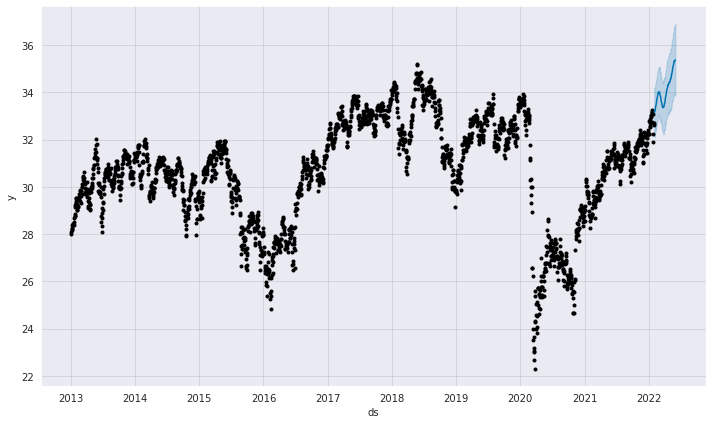

In [ ]:
fig1 = model.plot(forecast)


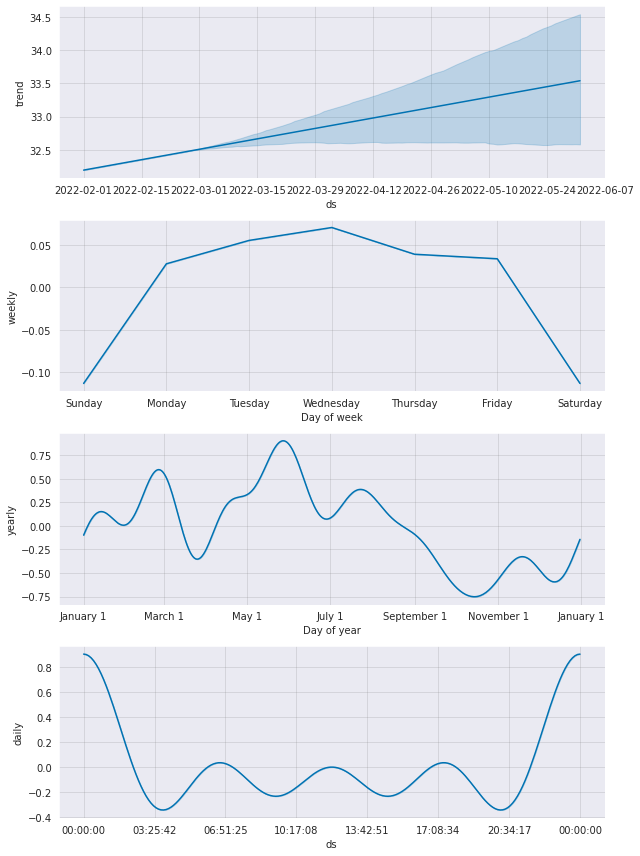

In [ ]:
fig2 = model.plot_components(forecast)


In [ ]:
from fbprophet.plot import plot_plotly, plot_components_plotly
#import plotly.graph_objects as go

plot_plotly(model, forecast)

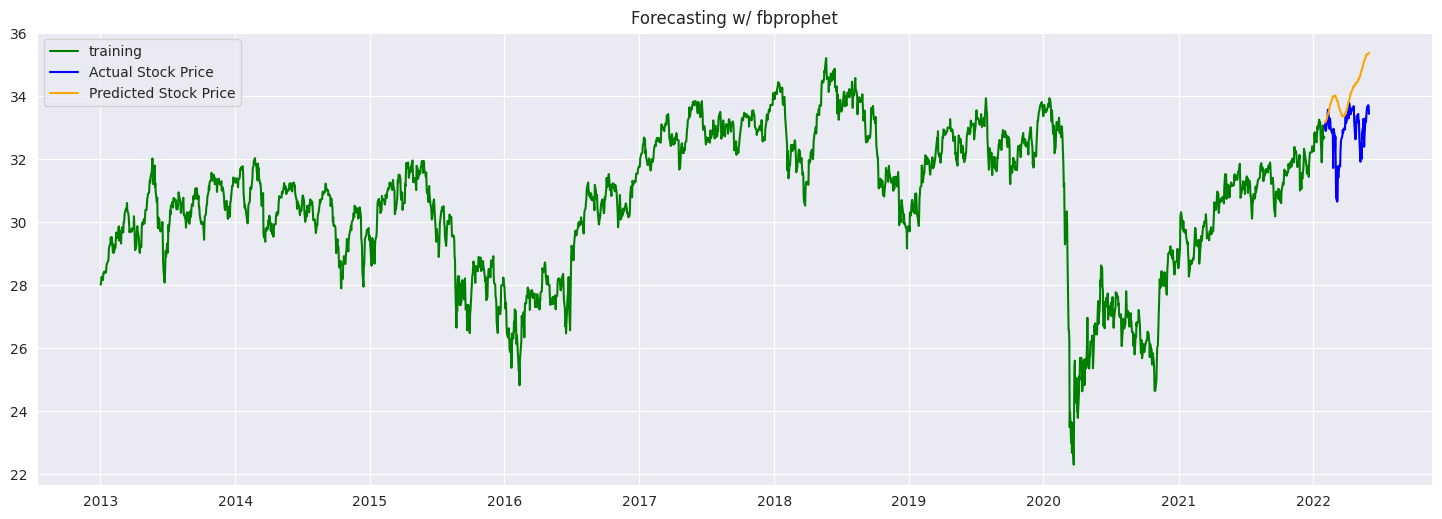

In [ ]:
plt.figure(figsize=(18,6), dpi=100)
plt.plot( ts_train, color='green', label='training')
plt.plot( ts_test, color = 'blue', label='Actual Stock Price')
plt.plot( fbfc, color = 'orange',label='Predicted Stock Price')
plt.title('Forecasting w/ fbprophet')
plt.legend(loc='best')
plt.show()

In [ ]:
# report performance
mse = mean_squared_error(ts_test, fbfc)
print('MSE: '+str(mse))
mae = mean_absolute_error(ts_test, fbfc)
print('MAE: '+str(mae))
rmse = np.sqrt(mean_squared_error(ts_test, fbfc))
print('RMSE: '+str(rmse))

results['fbprophet']=[mae, mse]

MSE: 2.1503593252597404
MAE: 1.1946959996569952
RMSE: 1.4664103536390285


# LSTM 2012

and Preprocessing With 1D-Convolutional Layers.

## Split the dataset: Train/test set  

In [ ]:
# split into train and test sets

split='2011'

ts_recent= (tsf['1993':'2012'])
ts_train=ts_recent[:split]
ts_test=ts_recent[ts_train.index[-1]+timedelta(days=1):'2012']
ts_test

Eto
Data                
2012-01-01  2.343399
2012-01-02  2.140238
2012-01-03  3.932297
2012-01-04  4.138469
2012-01-05  4.832823
...              ...
2012-12-27  5.330704
2012-12-28  5.224706
2012-12-29  3.295106
2012-12-30  5.815531
2012-12-31  6.165882

[366 rows x 1 columns]

In [ ]:
keras = tf.keras

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    

def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

## 1 step ahead

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(
                                      list(ts_train.values.flatten())
                                      , window_size)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      batch_input_shape=[1, None, 1],
                      input_shape=[None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                   # batch_input_shape=[1, None, 1]
                    ),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])


In [ ]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [ ]:
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))

reset_states = ResetStatesCallback()

optimizer = keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=10,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/10
231/231 [==============================] - 5s 8ms/step - loss: 5.7125 - mae: 6.1923 - lr: 1.0000e-08
Epoch 2/10
193/231 [========================>.....] - ETA: 0s - loss: 4.8231 - mae: 5.3028

KeyboardInterrupt: ignored

(1e-08, 0.0001, 0.0, 30.0)

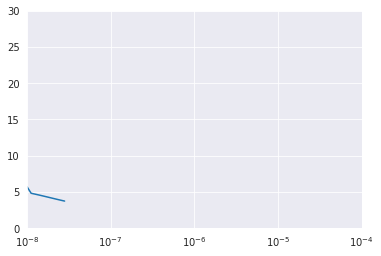

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])


In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = sequential_window_dataset(     list(ts_train.values.flatten())     , window_size)
valid_set = sequential_window_dataset(        list(ts_test.values.flatten())            , window_size)

model = keras.models.Sequential([
     keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      batch_input_shape=[1, None, 1],
                      input_shape=[None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         #batch_input_shape=[1, None, 1]
                    ),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(learning_rate=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

reset_states = ResetStatesCallback()

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint_rnn1.h5", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

# 500 epochs is better
model.fit(train_set, epochs=10,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/10
231/231 [==============================] - 5s 12ms/step - loss: 4.7586 - mae: 5.2380 - val_loss: 4.2658 - val_mae: 4.7453
Epoch 2/10
231/231 [==============================] - 2s 9ms/step - loss: 3.8470 - mae: 4.3241 - val_loss: 3.6636 - val_mae: 4.1409
Epoch 3/10
231/231 [==============================] - 2s 9ms/step - loss: 3.4242 - mae: 3.9012 - val_loss: 3.3147 - val_mae: 3.7886
Epoch 4/10
231/231 [==============================] - 2s 9ms/step - loss: 3.1437 - mae: 3.6152 - val_loss: 3.0851 - val_mae: 3.5591
Epoch 5/10
231/231 [==============================] - 2s 9ms/step - loss: 2.9317 - mae: 3.3997 - val_loss: 2.8927 - val_mae: 3.3631
Epoch 6/10
231/231 [==============================] - 2s 9ms/step - loss: 2.7479 - mae: 3.2140 - val_loss: 2.7103 - val_mae: 3.1776
Epoch 7/10
231/231 [==============================] - 2s 9ms/step - loss: 2.5772 - mae: 3.0424 - val_loss: 2.5338 - val_mae: 3.0018
Epoch 8/10
231/231 [==============================] - 2s 9ms/step - loss: 2

In [ ]:
model = keras.models.load_model("my_checkpoint_rnn1.h5")

In [ ]:
rnn_forecast = model.predict( ts_recent.values.flatten()[np.newaxis, :, np.newaxis])
#rnn_forecast = rnn_forecast[0, len(ts_train)-1 :-1, 0]

In [ ]:
rnn_forecast.shape

(1, 8400, 1)

In [ ]:
rnn_forecast = rnn_forecast[0, len(ts_train)-1:-1,0]
rnn_forecast.shape

(1461,)

In [ ]:
len(ts_train)

6939

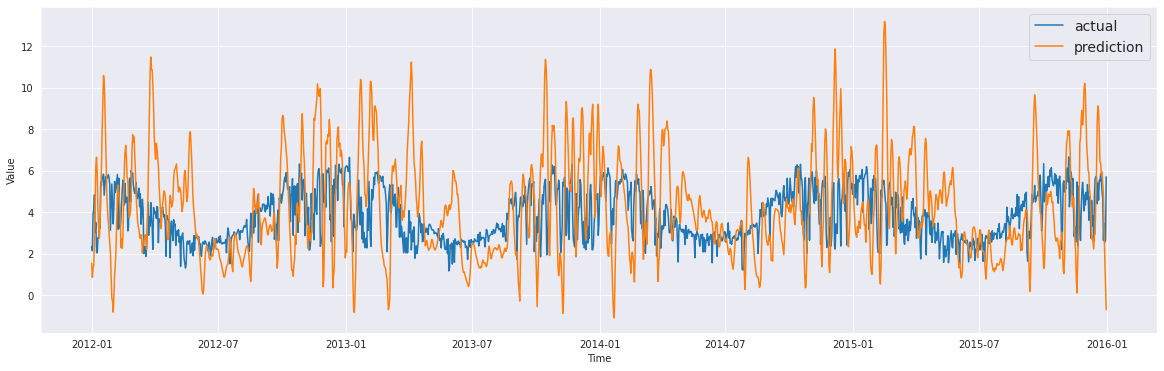

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test.index, ts_test.values, label="actual")
plot_series(ts_test.index, rnn_forecast, label="prediction")

In [ ]:
rnn_forecast[-5:-1,]

array([4.7774844, 3.2094054, 1.6445756, 0.4454568], dtype=float32)

In [ ]:
ts.tail()

Eto
Data                
2015-12-27  2.633047
2015-12-28  3.445454
2015-12-29  2.556850
2015-12-30  2.636948
2015-12-31  5.705485

In [ ]:
mae=keras.metrics.mean_absolute_error(ts_test.values.flatten(), rnn_forecast).numpy()
mae

1.9013411

In [ ]:
mse=keras.metrics.mean_squared_error(ts_test.values.flatten(), rnn_forecast).numpy()
mse

6.109828

In [ ]:
results['LSTM']=[mae, mse]

NameError: ignored



---




## 3 steps ahead 

In [ ]:
def window_dataset_atend(ts, window_size=30, target_length=1, batch_size=1):
    series=ts.values.flatten()
    series = tf.expand_dims(series, axis=-1)
    ds=tf.data.Dataset.from_tensor_slices(series)
    ds=ds.window(window_size+target_length, shift=1, drop_remainder=True)
    ds=ds.flat_map(lambda w: w.batch(window_size+target_length)  )
    ds=ds.map(lambda w: (w[:-target_length], w[-target_length:]) )
    ds=ds.shuffle(len(series))
    ds=ds.batch(batch_size).prefetch(1)
    #ds=ds.as_numpy_iterator()
    return ds

def window_dataset_eachstep(ts, window_size=30, target_length=1, batch_size=1):
    #series=ts.values.flatten()
    series=ts[:]
    series.columns=['0']
    for i in range(1,target_length+1):
        series[str(i)]=series['0'].shift(-i)
    series=series.iloc[:-target_length,:]
    #series = tf.expand_dims(series, axis=-1)
    ds=tf.data.Dataset.from_tensor_slices(series)
    ds=ds.window(window_size, shift=1, drop_remainder=True)
    ds=ds.flat_map(lambda w: w.batch(window_size)  )
    ds=ds.map(lambda w: (   tf.expand_dims(w[...,0], axis=-1)   , w[...,-target_length:]) )
    ds=ds.shuffle(len(series))
    ds=ds.batch(batch_size).prefetch(1)
    #ds=ds.as_numpy_iterator()
    return ds



In [ ]:
train_set=window_dataset_atend(ts_train, window_size=30, target_length=1)
valid_set=window_dataset_atend(ts_test,target_length=1)

In [ ]:
for x in train_set:
    print(x)
    break

In [ ]:
train_set=window_dataset_atend(ts_train, window_size=30, target_length=1)
valid_set=window_dataset_atend(ts_test,target_length=1)

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(10, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(10, return_sequences=False),
   # keras.layers.TimeDistributed(keras.layers.Dense(5))
    keras.layers.Dense(5)
])

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint_rnn5.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)


model.compile(loss="mse", optimizer='adam')

history = model.fit(train_set, epochs=20,
                    validation_data=valid_set
                    , callbacks=[early_stopping, model_checkpoint, reset_states]
                    )

Epoch 1/20
6909/6909 [==============================] - 57s 7ms/step - loss: 0.8863 - val_loss: 0.5615
Epoch 2/20
6909/6909 [==============================] - 47s 7ms/step - loss: 0.5428 - val_loss: 0.6206
Epoch 3/20
6909/6909 [==============================] - 46s 7ms/step - loss: 0.5303 - val_loss: 0.5501
Epoch 4/20
2212/6909 [========>.....................] - ETA: 28s - loss: 0.5208

KeyboardInterrupt: ignored

In [ ]:
model = keras.models.load_model("my_checkpoint_rnn5.h5")

In [ ]:
rnn_forecast = model.predict( valid_set)


In [ ]:
rnn_forecast.shape

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test[-5:].index, ts_test.values[-5:], label="actual")
plot_series(ts_test[-5:].index, rnn_forecast[-1,:], label="prediction")

```
# This is formatted as code
```

    def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

Another implementation of LSTM

In [ ]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=5)
valid_set=window_dataset_eachstep(ts_test,target_length=5)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=False),
    #keras.layers.TimeDistributed(keras.layers.Dense(5))
    keras.layers.Dense(5)
])

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint_rnn5b.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)


model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                    validation_data=valid_set
                    , callbacks=[early_stopping, model_checkpoint, reset_states]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 10), dtype=tf.float64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 10), dtype=tf.float64, name=None))>


ValueError: ignored

## 7 steps ahead 

In [ ]:
def window_dataset_atend(ts, window_size=30, target_length=1, batch_size=1):
    series=ts.values.flatten()
    series = tf.expand_dims(series, axis=-1)
    ds=tf.data.Dataset.from_tensor_slices(series)
    ds=ds.window(window_size+target_length, shift=1, drop_remainder=True)
    ds=ds.flat_map(lambda w: w.batch(window_size+target_length)  )
    ds=ds.map(lambda w: (w[:-target_length], w[-target_length:]) )
    ds=ds.shuffle(len(series))
    ds=ds.batch(batch_size).prefetch(1)
    #ds=ds.as_numpy_iterator()
    return ds

def window_dataset_eachstep(ts, window_size=30, target_length=1, batch_size=1):
    #series=ts.values.flatten()
    series=ts[:]
    series.columns=['0']
    for i in range(1,target_length+1):
        series[str(i)]=series['0'].shift(-i)
    series=series.iloc[:-target_length,:]
    #series = tf.expand_dims(series, axis=-1)
    ds=tf.data.Dataset.from_tensor_slices(series)
    ds=ds.window(window_size, shift=1, drop_remainder=True)
    ds=ds.flat_map(lambda w: w.batch(window_size)  )
    ds=ds.map(lambda w: (   tf.expand_dims(w[...,0], axis=-1)   , w[...,-target_length:]) )
    ds=ds.shuffle(len(series))
    ds=ds.batch(batch_size).prefetch(1)
    #ds=ds.as_numpy_iterator()
    return ds



In [ ]:
train_set=window_dataset_atend(ts_train, window_size=30, target_length=1)
valid_set=window_dataset_atend(ts_test,target_length=1)

In [ ]:
for x in train_set:
    print(x)
    break

In [ ]:
train_set=window_dataset_atend(ts_train, window_size=30, target_length=1)
valid_set=window_dataset_atend(ts_test,target_length=1)

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(10, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(10, return_sequences=False),
   # keras.layers.TimeDistributed(keras.layers.Dense(5))
    keras.layers.Dense(5)
])

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint_rnn5.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)


model.compile(loss="mse", optimizer='adam')

history = model.fit(train_set, epochs=20,
                    validation_data=valid_set
                    , callbacks=[early_stopping, model_checkpoint, reset_states]
                    )

Epoch 1/20
6909/6909 [==============================] - 57s 7ms/step - loss: 0.8863 - val_loss: 0.5615
Epoch 2/20
6909/6909 [==============================] - 47s 7ms/step - loss: 0.5428 - val_loss: 0.6206
Epoch 3/20
6909/6909 [==============================] - 46s 7ms/step - loss: 0.5303 - val_loss: 0.5501
Epoch 4/20
2212/6909 [========>.....................] - ETA: 28s - loss: 0.5208

KeyboardInterrupt: ignored

In [ ]:
model = keras.models.load_model("my_checkpoint_rnn5.h5")

In [ ]:
rnn_forecast = model.predict( valid_set)


In [ ]:
rnn_forecast.shape

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test[-5:].index, ts_test.values[-5:], label="actual")
plot_series(ts_test[-5:].index, rnn_forecast[-1,:], label="prediction")

```
# This is formatted as code
```

    def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

Another implementation of LSTM

In [ ]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=5)
valid_set=window_dataset_eachstep(ts_test,target_length=5)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=False),
    #keras.layers.TimeDistributed(keras.layers.Dense(5))
    keras.layers.Dense(5)
])

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint_rnn5b.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)


model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                    validation_data=valid_set
                    , callbacks=[early_stopping, model_checkpoint, reset_states]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 10), dtype=tf.float64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 10), dtype=tf.float64, name=None))>


ValueError: ignored

## 10 steps ahead 

In [ ]:
def window_dataset_atend(ts, window_size=30, target_length=1, batch_size=1):
    series=ts.values.flatten()
    series = tf.expand_dims(series, axis=-1)
    ds=tf.data.Dataset.from_tensor_slices(series)
    ds=ds.window(window_size+target_length, shift=1, drop_remainder=True)
    ds=ds.flat_map(lambda w: w.batch(window_size+target_length)  )
    ds=ds.map(lambda w: (w[:-target_length], w[-target_length:]) )
    ds=ds.shuffle(len(series))
    ds=ds.batch(batch_size).prefetch(1)
    #ds=ds.as_numpy_iterator()
    return ds

def window_dataset_eachstep(ts, window_size=30, target_length=1, batch_size=1):
    #series=ts.values.flatten()
    series=ts[:]
    series.columns=['0']
    for i in range(1,target_length+1):
        series[str(i)]=series['0'].shift(-i)
    series=series.iloc[:-target_length,:]
    #series = tf.expand_dims(series, axis=-1)
    ds=tf.data.Dataset.from_tensor_slices(series)
    ds=ds.window(window_size, shift=1, drop_remainder=True)
    ds=ds.flat_map(lambda w: w.batch(window_size)  )
    ds=ds.map(lambda w: (   tf.expand_dims(w[...,0], axis=-1)   , w[...,-target_length:]) )
    ds=ds.shuffle(len(series))
    ds=ds.batch(batch_size).prefetch(1)
    #ds=ds.as_numpy_iterator()
    return ds



In [ ]:
train_set=window_dataset_atend(ts_train, window_size=30, target_length=1)
valid_set=window_dataset_atend(ts_test,target_length=1)

In [ ]:
for x in train_set:
    print(x)
    break

In [ ]:
train_set=window_dataset_atend(ts_train, window_size=30, target_length=1)
valid_set=window_dataset_atend(ts_test,target_length=1)

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(10, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(10, return_sequences=False),
   # keras.layers.TimeDistributed(keras.layers.Dense(5))
    keras.layers.Dense(5)
])

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint_rnn5.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)


model.compile(loss="mse", optimizer='adam')

history = model.fit(train_set, epochs=20,
                    validation_data=valid_set
                    , callbacks=[early_stopping, model_checkpoint, reset_states]
                    )

Epoch 1/20
6909/6909 [==============================] - 57s 7ms/step - loss: 0.8863 - val_loss: 0.5615
Epoch 2/20
6909/6909 [==============================] - 47s 7ms/step - loss: 0.5428 - val_loss: 0.6206
Epoch 3/20
6909/6909 [==============================] - 46s 7ms/step - loss: 0.5303 - val_loss: 0.5501
Epoch 4/20
2212/6909 [========>.....................] - ETA: 28s - loss: 0.5208

KeyboardInterrupt: ignored

In [ ]:
model = keras.models.load_model("my_checkpoint_rnn5.h5")

In [ ]:
rnn_forecast = model.predict( valid_set)


In [ ]:
rnn_forecast.shape

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test[-5:].index, ts_test.values[-5:], label="actual")
plot_series(ts_test[-5:].index, rnn_forecast[-1,:], label="prediction")

```
# This is formatted as code
```

    def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

Another implementation of LSTM

In [ ]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=5)
valid_set=window_dataset_eachstep(ts_test,target_length=5)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=False),
    #keras.layers.TimeDistributed(keras.layers.Dense(5))
    keras.layers.Dense(5)
])

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint_rnn5b.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)


model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                    validation_data=valid_set
                    , callbacks=[early_stopping, model_checkpoint, reset_states]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 10), dtype=tf.float64, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 10), dtype=tf.float64, name=None))>


ValueError: ignored

# Wavenet 2012



## Split the dataset: Train/test set  

In [ ]:
# split into train and test sets

split='2011'

ts_recent= (tsf['1993':'2012'])
ts_train=ts_recent[:split]
ts_test=ts_recent[ts_train.index[-1]+timedelta(days=1):'2012']
ts_test

Eto
Data                
2012-01-01  2.343399
2012-01-02  2.140238
2012-01-03  3.932297
2012-01-04  4.138469
2012-01-05  4.832823
...              ...
2012-12-27  5.330704
2012-12-28  5.224706
2012-12-29  3.295106
2012-12-30  5.815531
2012-12-31  6.165882

[366 rows x 1 columns]

## 1 step ahead

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = sequential_window_dataset(     list(ts_train.values.flatten())     , window_size)
valid_set = sequential_window_dataset(        list(ts_test.values.flatten())            , window_size)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, 
                                  kernel_size=2, 
                                  padding="causal",
                                  activation="relu", 
                                  dilation_rate=rate))
    
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Adam(learning_rate=3e-3)

model.compile(loss='mse',
              optimizer=optimizer, 
              metrics=['mae'])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                    callbacks=[lr_schedule]
                    )

Epoch 1/20
231/231 [==============================] - 7s 17ms/step - loss: 8.5829 - mae: 2.5566 - val_loss: 3.7129 - val_mae: 1.4973 - lr: 1.0000e-04
Epoch 2/20
231/231 [==============================] - 2s 10ms/step - loss: 2.0933 - mae: 1.0738 - val_loss: 1.4850 - val_mae: 0.9165 - lr: 1.0798e-04
Epoch 3/20
231/231 [==============================] - 2s 11ms/step - loss: 1.0074 - mae: 0.7459 - val_loss: 0.8818 - val_mae: 0.7250 - lr: 1.1659e-04
Epoch 4/20
231/231 [==============================] - 2s 10ms/step - loss: 0.7066 - mae: 0.6420 - val_loss: 0.7006 - val_mae: 0.6475 - lr: 1.2589e-04
Epoch 5/20
231/231 [==============================] - 2s 10ms/step - loss: 0.6018 - mae: 0.5937 - val_loss: 0.6696 - val_mae: 0.6263 - lr: 1.3594e-04
Epoch 6/20
231/231 [==============================] - 2s 8ms/step - loss: 0.5688 - mae: 0.5734 - val_loss: 0.6582 - val_mae: 0.6166 - lr: 1.4678e-04
Epoch 7/20
231/231 [==============================] - 2s 9ms/step - loss: 0.5504 - mae: 0.5598 - val_

(0.0001, 0.1, 0.0, 30.0)

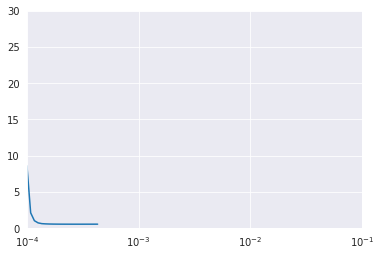

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = sequential_window_dataset(     list(ts_train.values.flatten())     , window_size)
valid_set = sequential_window_dataset(        list(ts_test.values.flatten())            , window_size)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, 
                                  kernel_size=2, 
                                  padding="causal",
                                  activation="relu", 
                                  dilation_rate=rate))
    
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))


optimizer = keras.optimizers.Adam(learning_rate=6.5e-4)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint_wvn1.h5", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer, 
              metrics='mae')

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                     callbacks=[early_stopping, model_checkpoint])
                    

Epoch 1/20
231/231 [==============================] - 6s 14ms/step - loss: 0.7776 - mae: 1.1596 - val_loss: 0.3292 - val_mae: 0.6654
Epoch 2/20
231/231 [==============================] - 1s 6ms/step - loss: 0.2624 - mae: 0.5784 - val_loss: 0.2899 - val_mae: 0.6076
Epoch 3/20
231/231 [==============================] - 1s 6ms/step - loss: 0.2421 - mae: 0.5432 - val_loss: 0.2807 - val_mae: 0.5893
Epoch 4/20
231/231 [==============================] - 1s 6ms/step - loss: 0.2386 - mae: 0.5359 - val_loss: 0.2791 - val_mae: 0.5859
Epoch 5/20
231/231 [==============================] - 2s 7ms/step - loss: 0.2372 - mae: 0.5332 - val_loss: 0.2784 - val_mae: 0.5839
Epoch 6/20
231/231 [==============================] - 1s 6ms/step - loss: 0.2366 - mae: 0.5322 - val_loss: 0.2782 - val_mae: 0.5842
Epoch 7/20
231/231 [==============================] - 1s 6ms/step - loss: 0.2360 - mae: 0.5312 - val_loss: 0.2786 - val_mae: 0.5843
Epoch 8/20
231/231 [==============================] - 1s 6ms/step - loss: 0

In [ ]:
model = keras.models.load_model("my_checkpoint_wvn1.h5")

In [ ]:
wavenet_forecast = model.predict( ts_recent.values.flatten()[np.newaxis, :, np.newaxis])
#rnn_forecast = rnn_forecast[0, len(ts_train)-1 :-1, 0]

In [ ]:
wavenet_forecast.shape

(1, 7305, 1)

In [ ]:
wavenet_forecast = wavenet_forecast[0, len(ts_train)-1 :-1,0]
wavenet_forecast.shape

(366,)

In [ ]:
len(ts_train)

6939

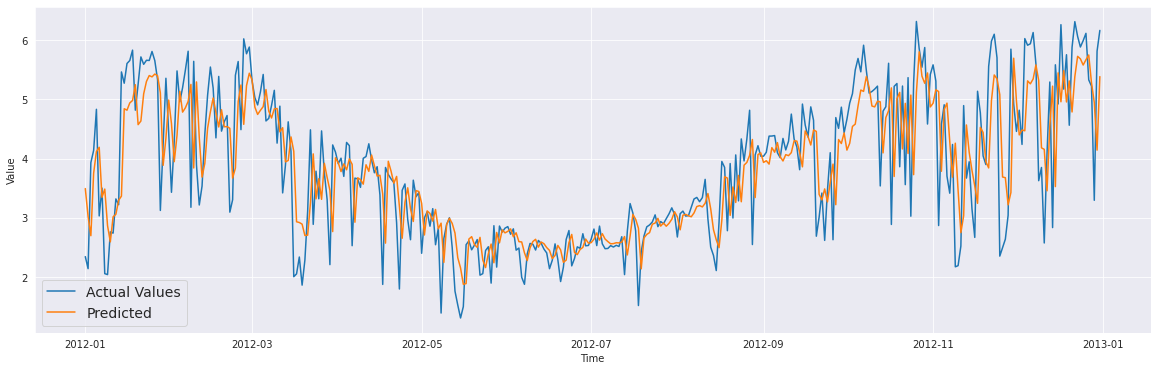

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test.index, ts_test.values, label='Actual Values')
plot_series(ts_test.index, wavenet_forecast[:], label='Predicted')

In [ ]:
wavenet_forecast[-5:-1,]

array([5.75081  , 5.2783566, 4.947775 , 4.1432266], dtype=float32)

In [ ]:
ts.tail()

Eto
Data                
2015-12-27  2.633047
2015-12-28  3.445454
2015-12-29  2.556850
2015-12-30  2.636948
2015-12-31  5.705485

In [ ]:
mae=keras.metrics.mean_absolute_error(ts_test.values.flatten(), wavenet_forecast).numpy()
mae

0.56374913

In [ ]:
mse=keras.metrics.mean_squared_error(ts_test.values.flatten(), wavenet_forecast).numpy()
mse

0.60808516

In [ ]:
import math
rmse=math.sqrt(mse)
rmse

0.7797981504768144

In [ ]:
results['WaveNet-2012-1']=[mae, mse, rmse]

## 3 steps ahead

In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=3)
valid_set=window_dataset_eachstep(ts_test,target_length=3)

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=3, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Adam(learning_rate=3e-3)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                    callbacks=[lr_schedule]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/20
6907/6907 [==============================] - 42s 6ms/step - loss: 1.1063 - last_time_step_mse: 0.9981 - val_loss: 0.6889 - val_last_time_step_mse: 0.6786 - lr: 1.0000e-04
Epoch 2/20
6907/6907 [==============================] - 42s 6ms/step - loss: 0.6712 - last_time_step_mse: 0.6567 - val_loss: 0.6817 - val_last_time_step_mse: 0.6737 - lr: 1.0798e-04
Epoch 3/20
6907/6907 [==============================] - 39s 6ms/step - loss: 0.6680 - last_time_step_mse: 0.6555 - val_loss: 0.6878 - val_last_time_step_mse: 0.6847 - lr: 1.1659e-04
Epoch 4/20
6907/6907 [==============================] - 41s 6ms/step - loss: 0.6658 - last_time_step_mse: 0.6550 - val_loss: 0.7126 - val_last_time_step_mse: 0.6997 - lr: 1.2589e-04
Epoch 5/20
6907/6907 [==============================] - 40s 6ms/step - loss: 0.6646 - last_time_step_mse: 0.6535 - val_loss: 0.6909 - val_last_time_step_mse: 0.6886 - lr: 1.3594e-04
Epoch 6/20
6907/6907 [==============================] - 40s 6ms/step - loss: 0.6627 - last

(1e-05, 0.1, 0.0, 3.0)

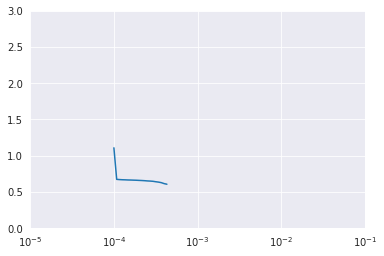

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 3])

In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=3)
valid_set=window_dataset_eachstep(ts_test,target_length=3)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=3, kernel_size=1))


optimizer = keras.optimizers.Adam(learning_rate=2e-4)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                   # callbacks=[lr_schedule]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/20
6907/6907 [==============================] - 56s 8ms/step - loss: 0.9113 - last_time_step_mse: 0.8563 - val_loss: 0.6972 - val_last_time_step_mse: 0.6887
Epoch 2/20
6907/6907 [==============================] - 41s 6ms/step - loss: 0.6707 - last_time_step_mse: 0.6580 - val_loss: 0.6796 - val_last_time_step_mse: 0.6753
Epoch 3/20
6907/6907 [==============================] - 41s 6ms/step - loss: 0.6666 - last_time_step_mse: 0.6532 - val_loss: 0.6805 - val_last_time_step_mse: 0.6786
Epoch 4/20
6907/6907 [==============================] - 40s 6ms/step - loss: 0.6626 - last_time_step_mse: 0.6516 - val_loss: 0.7189 - val_last_time_step_mse: 0.7033
Epoch 5/20
6907/6907 [==============================] - 40s 6ms/step - loss: 0.6597 - last_time_step_mse: 0.6486 - val_loss: 0.6995 - val_last_time_step_mse: 0.6992
Epoch 6/20
6907/6907 [==============================] - 41s 6ms/step - loss: 0.6562 - last_time_step_mse: 0.6402 - val_loss: 0.6826 - val_last_time_step_mse: 0.6844
Epoch 7/20

In [ ]:
wav5_forecast = model.predict(valid_set)


In [ ]:
wav5_forecast.shape

(334, 30, 3)

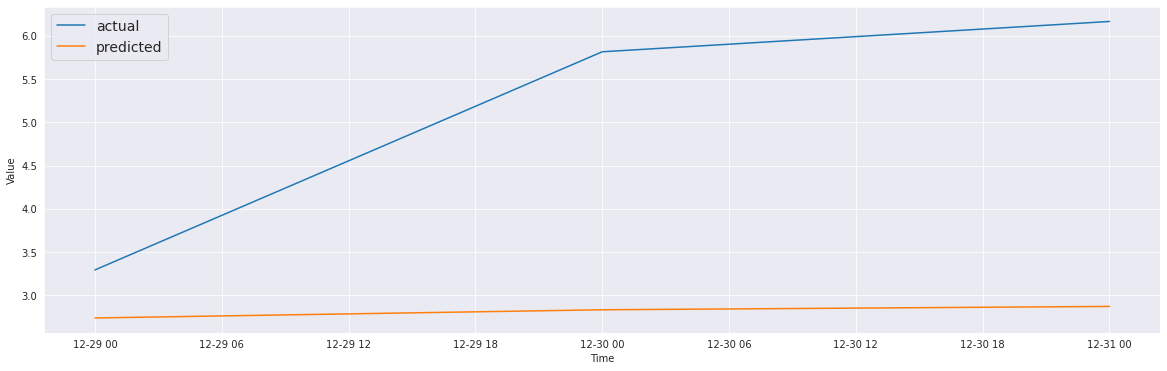

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test[-3:].index, ts_test.values[-3:], label='actual')
plot_series(ts_test[-3:].index, wav5_forecast[-1,-1,:], label='predicted')

In [ ]:
mae=keras.metrics.mean_absolute_error(ts_test.values[:3].flatten(), wav5_forecast[-1,-1,:]).numpy()
mae

0.71663505

In [ ]:
mse=keras.metrics.mean_squared_error(ts_test.values[:3].flatten(), wav5_forecast[-1,-1,:]).numpy()
mse

0.5869705

In [ ]:
import math
rmse=math.sqrt(mse)
rmse
# 0.76614

0.9397136821655048

In [ ]:
results['WaveNet12-3']=[mae, mse, rmse]

## 7 steps ahead

In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=7)
valid_set=window_dataset_eachstep(ts_test,target_length=7)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=7, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Adam(learning_rate=3e-3)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                    callbacks=[lr_schedule]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/20
6903/6903 [==============================] - 44s 6ms/step - loss: 1.2882 - last_time_step_mse: 1.1163 - val_loss: 0.7617 - val_last_time_step_mse: 0.7489 - lr: 1.0000e-04
Epoch 2/20
6903/6903 [==============================] - 40s 6ms/step - loss: 0.7797 - last_time_step_mse: 0.7607 - val_loss: 0.7519 - val_last_time_step_mse: 0.7476 - lr: 1.0798e-04
Epoch 3/20
6903/6903 [==============================] - 41s 6ms/step - loss: 0.7714 - last_time_step_mse: 0.7505 - val_loss: 0.7474 - val_last_time_step_mse: 0.7396 - lr: 1.1659e-04
Epoch 4/20
6903/6903 [==============================] - 39s 6ms/step - loss: 0.7657 - last_time_step_mse: 0.7439 - val_loss: 0.7468 - val_last_time_step_mse: 0.7398 - lr: 1.2589e-04
Epoch 5/20
6903/6903 [==============================] - 39s 6ms/step - loss: 0.7617 - last_time_step_mse: 0.7431 - val_loss: 0.7632 - val_last_time_step_mse: 0.7697 - lr: 1.3594e-04
Epoch 6/20
6903/6903 [==============================] - 45s 6ms/step - loss: 0.7579 - last

(1e-05, 0.1, 0.0, 3.0)

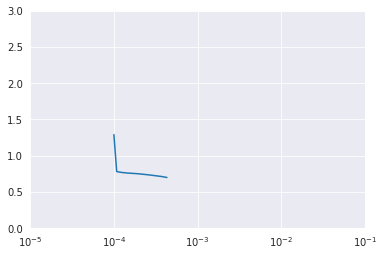

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 3])


In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=7)
valid_set=window_dataset_eachstep(ts_test,target_length=7)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=7, kernel_size=1))


optimizer = keras.optimizers.Adam(learning_rate=2e-4)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                   # callbacks=[lr_schedule]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/20
6903/6903 [==============================] - 62s 8ms/step - loss: 1.0646 - last_time_step_mse: 0.9702 - val_loss: 0.7638 - val_last_time_step_mse: 0.7524
Epoch 2/20
6903/6903 [==============================] - 40s 6ms/step - loss: 0.7756 - last_time_step_mse: 0.7584 - val_loss: 0.7489 - val_last_time_step_mse: 0.7433
Epoch 3/20
6903/6903 [==============================] - 41s 6ms/step - loss: 0.7660 - last_time_step_mse: 0.7451 - val_loss: 0.7456 - val_last_time_step_mse: 0.7412
Epoch 4/20
6903/6903 [==============================] - 40s 6ms/step - loss: 0.7590 - last_time_step_mse: 0.7372 - val_loss: 0.7445 - val_last_time_step_mse: 0.7393
Epoch 5/20
6903/6903 [==============================] - 41s 6ms/step - loss: 0.7542 - last_time_step_mse: 0.7335 - val_loss: 0.7721 - val_last_time_step_mse: 0.7830
Epoch 6/20
6903/6903 [==============================] - 39s 6ms/step - loss: 0.7487 - last_time_step_mse: 0.7290 - val_loss: 0.7523 - val_last_time_step_mse: 0.7578
Epoch 7/20

In [ ]:
wav5_forecast = model.predict(valid_set)


In [ ]:
wav5_forecast.shape

(330, 30, 7)

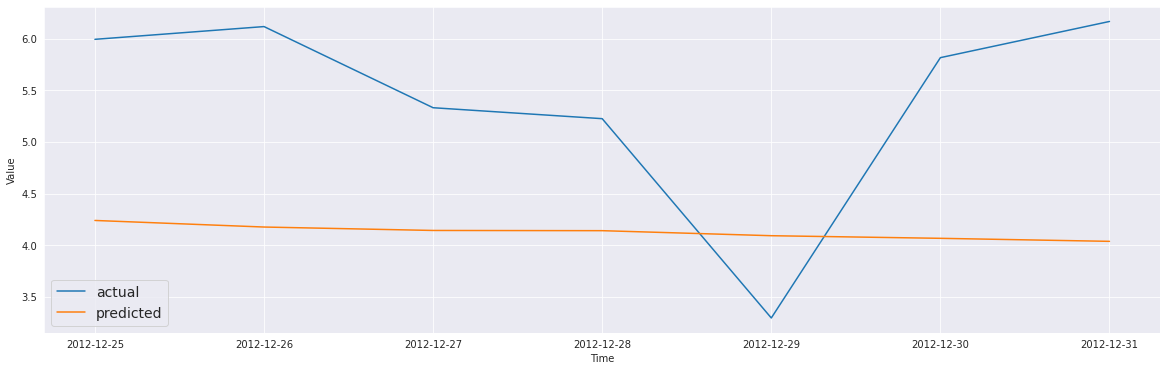

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test[-7:].index, ts_test.values[-7:], label='actual')
plot_series(ts_test[-7:].index, wav5_forecast[-1,-1,:], label='predicted')

In [ ]:
mae=keras.metrics.mean_absolute_error(ts_test.values[:7].flatten(), wav5_forecast[-1,-1,:]).numpy()
mae

0.92214745

In [ ]:
mse=keras.metrics.mean_squared_error(ts_test.values[:7].flatten(), wav5_forecast[-1,-1,:]).numpy()
mse

1.3840739

In [ ]:
import math
rmse=math.sqrt(mse)
rmse
# 1.17

0.9693883030888627

In [ ]:
results['WaveNet12-7']=[mae, mse, rmse]

## 10 steps ahead

In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=10)
valid_set=window_dataset_eachstep(ts_test,target_length=10)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Adam(learning_rate=3e-3)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                    callbacks=[lr_schedule]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/20
6900/6900 [==============================] - 64s 9ms/step - loss: 1.3588 - last_time_step_mse: 1.2254 - val_loss: 0.7972 - val_last_time_step_mse: 0.7877 - lr: 1.0000e-04
Epoch 2/20
6900/6900 [==============================] - 54s 8ms/step - loss: 0.8180 - last_time_step_mse: 0.8019 - val_loss: 0.7850 - val_last_time_step_mse: 0.7731 - lr: 1.0798e-04
Epoch 3/20
6900/6900 [==============================] - 51s 7ms/step - loss: 0.8124 - last_time_step_mse: 0.7978 - val_loss: 0.8245 - val_last_time_step_mse: 0.7995 - lr: 1.1659e-04
Epoch 4/20
6900/6900 [==============================] - 40s 6ms/step - loss: 0.8055 - last_time_step_mse: 0.7914 - val_loss: 0.8228 - val_last_time_step_mse: 0.8312 - lr: 1.2589e-04
Epoch 5/20
6900/6900 [==============================] - 67s 10ms/step - loss: 0.8027 - last_time_step_mse: 0.7878 - val_loss: 0.7913 - val_last_time_step_mse: 0.7830 - lr: 1.3594e-04
Epoch 6/20
6900/6900 [==============================] - 41s 6ms/step - loss: 0.7977 - las

(1e-05, 0.1, 0.0, 3.0)

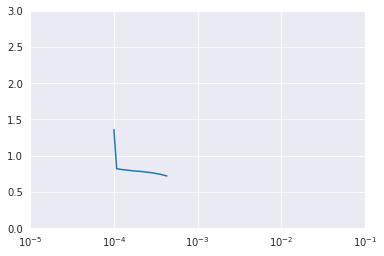

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 3])


In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=10)
valid_set=window_dataset_eachstep(ts_test,target_length=10)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))


optimizer = keras.optimizers.Adam(learning_rate=2e-4)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                   # callbacks=[lr_schedule]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/20
6900/6900 [==============================] - 43s 6ms/step - loss: 1.1192 - last_time_step_mse: 1.0514 - val_loss: 0.8107 - val_last_time_step_mse: 0.8029
Epoch 2/20
6900/6900 [==============================] - 40s 6ms/step - loss: 0.8170 - last_time_step_mse: 0.8002 - val_loss: 0.7858 - val_last_time_step_mse: 0.7751
Epoch 3/20
6900/6900 [==============================] - 40s 6ms/step - loss: 0.8096 - last_time_step_mse: 0.7922 - val_loss: 0.8422 - val_last_time_step_mse: 0.8112
Epoch 4/20
6900/6900 [==============================] - 40s 6ms/step - loss: 0.8006 - last_time_step_mse: 0.7846 - val_loss: 0.8338 - val_last_time_step_mse: 0.8461
Epoch 5/20
6900/6900 [==============================] - 41s 6ms/step - loss: 0.7966 - last_time_step_mse: 0.7792 - val_loss: 0.7828 - val_last_time_step_mse: 0.7732
Epoch 6/20
6900/6900 [==============================] - 44s 6ms/step - loss: 0.7911 - last_time_step_mse: 0.7684 - val_loss: 0.7695 - val_last_time_step_mse: 0.7603
Epoch 7/20

In [ ]:
wav5_forecast = model.predict(valid_set)


In [ ]:
wav5_forecast.shape

(327, 30, 10)

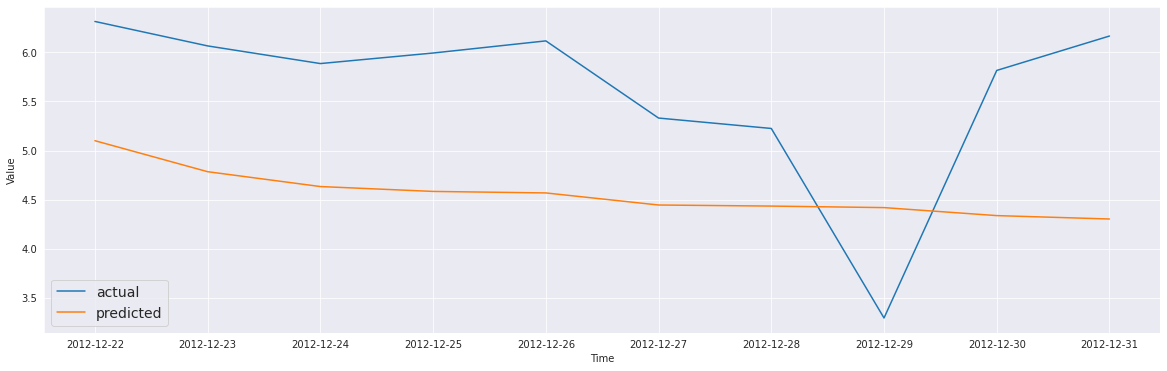

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test[-10:].index, ts_test.values[-10:], label='actual')
plot_series(ts_test[-10:].index, wav5_forecast[-1,-1,:], label='predicted')

In [ ]:
mae=keras.metrics.mean_absolute_error(ts_test.values[:10].flatten(), wav5_forecast[-1,-1,:]).numpy()
mae

1.53603

In [ ]:
mse=keras.metrics.mean_squared_error(ts_test.values[:10].flatten(), wav5_forecast[-1,-1,:]).numpy()
mse
# 1.77

3.145745

In [ ]:
import math
rmse=math.sqrt(mse)
rmse

0.9845751891495452

In [ ]:
results['WaveNet12-10']=[mae, mse, rmse]

# Wavenet 2013



## Split the dataset: Train/test set  

In [ ]:
# split into train and test sets

split='2011'

ts_recent= (tsf['1993':'2013'])
ts_train=ts_recent[:split]
ts_test=ts_recent['2013-01-01':'2013-12-31']
ts_test

Eto
Data                
2013-01-01  6.192321
2013-01-02  6.242781
2013-01-03  6.167494
2013-01-04  5.964811
2013-01-05  5.963090
...              ...
2013-12-27  4.813007
2013-12-28  4.619651
2013-12-29  4.896986
2013-12-30  2.881817
2013-12-31  3.455163

[365 rows x 1 columns]

## 1 step ahead

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = sequential_window_dataset(     list(ts_train.values.flatten())     , window_size)
valid_set = sequential_window_dataset(        list(ts_test.values.flatten())            , window_size)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, 
                                  kernel_size=2, 
                                  padding="causal",
                                  activation="relu", 
                                  dilation_rate=rate))
    
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Adam(learning_rate=3e-3)

model.compile(loss='mse',
              optimizer=optimizer, 
              metrics=['mae'])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                    callbacks=[lr_schedule]
                    )

Epoch 1/20
231/231 [==============================] - 5s 9ms/step - loss: 8.5829 - mae: 2.5566 - val_loss: 3.4806 - val_mae: 1.4452 - lr: 1.0000e-04
Epoch 2/20
231/231 [==============================] - 1s 6ms/step - loss: 2.0933 - mae: 1.0738 - val_loss: 1.4888 - val_mae: 0.9112 - lr: 1.0798e-04
Epoch 3/20
231/231 [==============================] - 1s 6ms/step - loss: 1.0074 - mae: 0.7459 - val_loss: 0.9985 - val_mae: 0.7690 - lr: 1.1659e-04
Epoch 4/20
231/231 [==============================] - 1s 6ms/step - loss: 0.7066 - mae: 0.6420 - val_loss: 0.7944 - val_mae: 0.6842 - lr: 1.2589e-04
Epoch 5/20
231/231 [==============================] - 1s 6ms/step - loss: 0.6018 - mae: 0.5937 - val_loss: 0.7252 - val_mae: 0.6531 - lr: 1.3594e-04
Epoch 6/20
231/231 [==============================] - 1s 6ms/step - loss: 0.5688 - mae: 0.5734 - val_loss: 0.6820 - val_mae: 0.6320 - lr: 1.4678e-04
Epoch 7/20
231/231 [==============================] - 2s 7ms/step - loss: 0.5504 - mae: 0.5598 - val_loss:

(0.0001, 0.1, 0.0, 30.0)

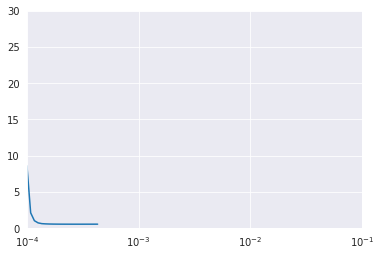

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = sequential_window_dataset(     list(ts_train.values.flatten())     , window_size)
valid_set = sequential_window_dataset(        list(ts_test.values.flatten())            , window_size)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, 
                                  kernel_size=2, 
                                  padding="causal",
                                  activation="relu", 
                                  dilation_rate=rate))
    
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))


optimizer = keras.optimizers.Adam(learning_rate=6.5e-4)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint_wvn1.h5", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer, 
              metrics='mae')

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                     callbacks=[early_stopping, model_checkpoint])
                    

Epoch 1/20
231/231 [==============================] - 4s 8ms/step - loss: 0.7776 - mae: 1.1596 - val_loss: 0.3438 - val_mae: 0.6849
Epoch 2/20
231/231 [==============================] - 1s 6ms/step - loss: 0.2624 - mae: 0.5784 - val_loss: 0.2904 - val_mae: 0.6148
Epoch 3/20
231/231 [==============================] - 1s 6ms/step - loss: 0.2421 - mae: 0.5432 - val_loss: 0.2776 - val_mae: 0.5943
Epoch 4/20
231/231 [==============================] - 1s 6ms/step - loss: 0.2386 - mae: 0.5359 - val_loss: 0.2766 - val_mae: 0.5931
Epoch 5/20
231/231 [==============================] - 1s 6ms/step - loss: 0.2372 - mae: 0.5332 - val_loss: 0.2777 - val_mae: 0.5944
Epoch 6/20
231/231 [==============================] - 1s 6ms/step - loss: 0.2366 - mae: 0.5322 - val_loss: 0.2762 - val_mae: 0.5926
Epoch 7/20
231/231 [==============================] - 1s 6ms/step - loss: 0.2360 - mae: 0.5312 - val_loss: 0.2764 - val_mae: 0.5928
Epoch 8/20
231/231 [==============================] - 1s 6ms/step - loss: 0.

In [ ]:
model = keras.models.load_model("my_checkpoint_wvn1.h5")

In [ ]:
wavenet_forecast = model.predict( ts_recent.values.flatten()[np.newaxis, :, np.newaxis])
#rnn_forecast = rnn_forecast[0, len(ts_train)-1 :-1, 0]

In [ ]:
wavenet_forecast.shape

(1, 7670, 1)

In [ ]:
wavenet_forecast = wavenet_forecast[0, len(ts_train)+366-1 :-1,0]
wavenet_forecast.shape

(365,)

In [ ]:
len(ts_train)

6939

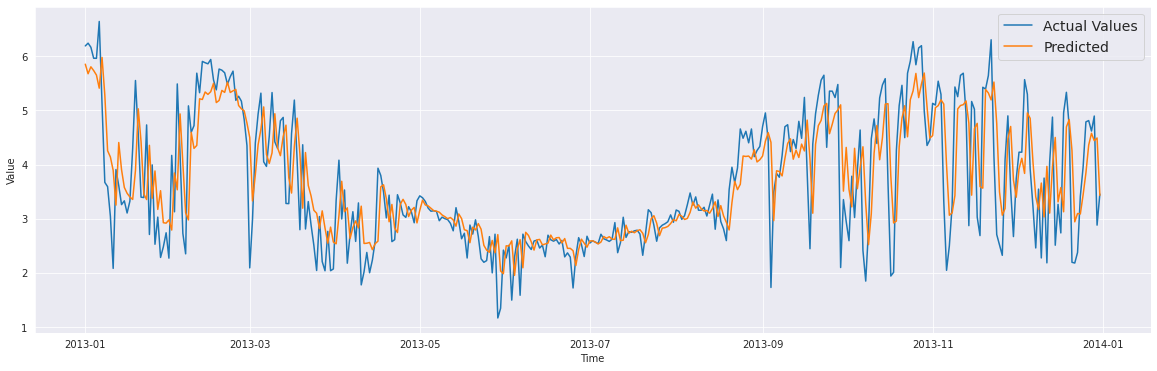

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test.index, ts_test.values, label='Actual Values')
plot_series(ts_test.index, wavenet_forecast, label='Predicted')

In [ ]:
wavenet_forecast[-5:-1,]

array([4.3607817, 4.578385 , 4.44114  , 4.491564 ], dtype=float32)

In [ ]:
ts.tail()

Eto
Data                
2015-12-27  2.633047
2015-12-28  3.445454
2015-12-29  2.556850
2015-12-30  2.636948
2015-12-31  5.705485

In [ ]:
mae=keras.metrics.mean_absolute_error(ts_test.values.flatten(), wavenet_forecast).numpy()
mae

0.5671662

In [ ]:
mse=keras.metrics.mean_squared_error(ts_test.values.flatten(), wavenet_forecast).numpy()
mse

0.610032

In [ ]:
import math
rmse=math.sqrt(mse)
rmse
# 0.7810454673060712

0.7810454673060712

In [ ]:
results['WaveNet-13-1']=[mae, mse, rmse]

## 3 steps ahead

In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=3)
valid_set=window_dataset_eachstep(ts_test,target_length=3)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=3, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Adam(learning_rate=3e-3)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                    callbacks=[lr_schedule]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/20
6907/6907 [==============================] - 42s 6ms/step - loss: 1.0903 - last_time_step_mse: 0.9925 - val_loss: 0.7766 - val_last_time_step_mse: 0.7775 - lr: 1.0000e-04
Epoch 2/20
6907/6907 [==============================] - 40s 6ms/step - loss: 0.6713 - last_time_step_mse: 0.6588 - val_loss: 0.7922 - val_last_time_step_mse: 0.7857 - lr: 1.0798e-04
Epoch 3/20
6907/6907 [==============================] - 39s 6ms/step - loss: 0.6679 - last_time_step_mse: 0.6561 - val_loss: 0.7651 - val_last_time_step_mse: 0.7676 - lr: 1.1659e-04
Epoch 4/20
6907/6907 [==============================] - 39s 6ms/step - loss: 0.6648 - last_time_step_mse: 0.6528 - val_loss: 0.7600 - val_last_time_step_mse: 0.7568 - lr: 1.2589e-04
Epoch 5/20
6907/6907 [==============================] - 39s 6ms/step - loss: 0.6630 - last_time_step_mse: 0.6521 - val_loss: 0.7592 - val_last_time_step_mse: 0.7607 - lr: 1.3594e-04
Epoch 6/20
6907/6907 [==============================] - 40s 6ms/step - loss: 0.6617 - last

(1e-05, 0.1, 0.0, 3.0)

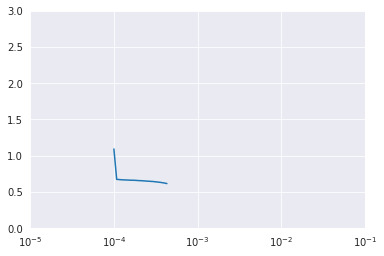

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 3])

In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=3)
valid_set=window_dataset_eachstep(ts_test,target_length=3)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=3, kernel_size=1))


optimizer = keras.optimizers.Adam(learning_rate=2e-4)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                   # callbacks=[lr_schedule]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/20
6907/6907 [==============================] - 40s 6ms/step - loss: 0.9113 - last_time_step_mse: 0.8563 - val_loss: 0.7692 - val_last_time_step_mse: 0.7712
Epoch 2/20
6907/6907 [==============================] - 39s 6ms/step - loss: 0.6707 - last_time_step_mse: 0.6579 - val_loss: 0.7638 - val_last_time_step_mse: 0.7656
Epoch 3/20
6907/6907 [==============================] - 40s 6ms/step - loss: 0.6666 - last_time_step_mse: 0.6532 - val_loss: 0.7599 - val_last_time_step_mse: 0.7646
Epoch 4/20
6907/6907 [==============================] - 39s 6ms/step - loss: 0.6625 - last_time_step_mse: 0.6516 - val_loss: 0.7699 - val_last_time_step_mse: 0.7669
Epoch 5/20
6907/6907 [==============================] - 39s 6ms/step - loss: 0.6596 - last_time_step_mse: 0.6486 - val_loss: 0.7597 - val_last_time_step_mse: 0.7644
Epoch 6/20
6907/6907 [==============================] - 39s 6ms/step - loss: 0.6562 - last_time_step_mse: 0.6402 - val_loss: 0.7598 - val_last_time_step_mse: 0.7612
Epoch 7/20

In [ ]:
wav5_forecast = model.predict(valid_set)


In [ ]:
wav5_forecast.shape

(333, 30, 3)

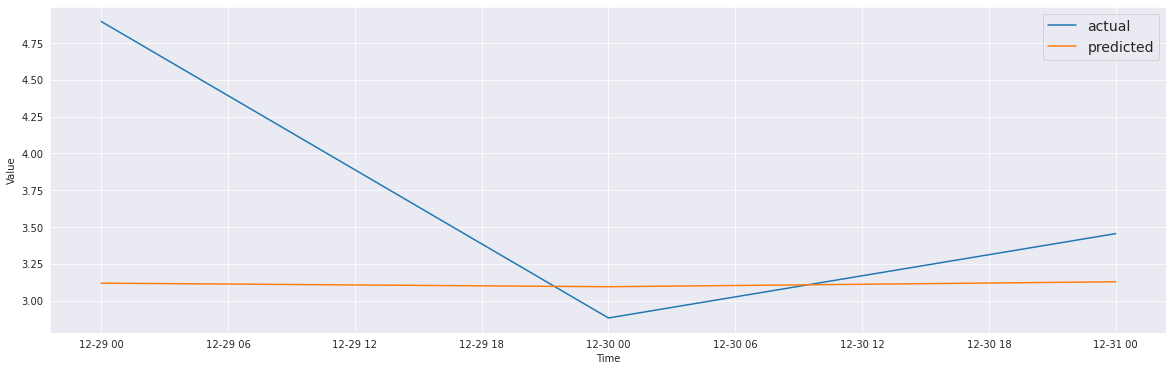

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test[-3:].index, ts_test.values[-3:], label='actual')
plot_series(ts_test[-3:].index, wav5_forecast[-1,-1,:], label='predicted')

In [ ]:
mae=keras.metrics.mean_absolute_error(ts_test.values[:3].flatten(), wav5_forecast[-1,-1,:]).numpy()
mae

3.087405

In [ ]:
mse=keras.metrics.mean_squared_error(ts_test.values[:3].flatten(), wav5_forecast[-1,-1,:]).numpy()
mse

9.534137

In [ ]:
import math
rmse=math.sqrt(mse)
rmse

0.8837677677456172

In [ ]:
results['WaveNet13-3']=[mae, mse, rmse]

## 7 steps ahead

In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=7)
valid_set=window_dataset_eachstep(ts_test,target_length=7)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=7, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Adam(learning_rate=3e-3)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                    callbacks=[lr_schedule]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/20
6903/6903 [==============================] - 41s 6ms/step - loss: 1.2882 - last_time_step_mse: 1.1163 - val_loss: 0.8672 - val_last_time_step_mse: 0.8572 - lr: 1.0000e-04
Epoch 2/20
6903/6903 [==============================] - 38s 5ms/step - loss: 0.7797 - last_time_step_mse: 0.7607 - val_loss: 0.8544 - val_last_time_step_mse: 0.8424 - lr: 1.0798e-04
Epoch 3/20
6903/6903 [==============================] - 39s 6ms/step - loss: 0.7712 - last_time_step_mse: 0.7501 - val_loss: 0.8566 - val_last_time_step_mse: 0.8388 - lr: 1.1659e-04
Epoch 4/20
6903/6903 [==============================] - 40s 6ms/step - loss: 0.7652 - last_time_step_mse: 0.7432 - val_loss: 0.8449 - val_last_time_step_mse: 0.8360 - lr: 1.2589e-04
Epoch 5/20
6903/6903 [==============================] - 39s 6ms/step - loss: 0.7610 - last_time_step_mse: 0.7419 - val_loss: 0.8510 - val_last_time_step_mse: 0.8469 - lr: 1.3594e-04
Epoch 6/20
6903/6903 [==============================] - 39s 6ms/step - loss: 0.7569 - last

(1e-05, 0.1, 0.0, 3.0)

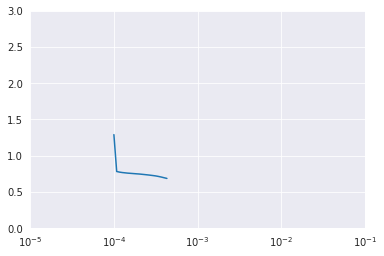

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 3])


In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=7)
valid_set=window_dataset_eachstep(ts_test,target_length=7)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=7, kernel_size=1))


optimizer = keras.optimizers.Adam(learning_rate=2e-4)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                   # callbacks=[lr_schedule]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/20
6903/6903 [==============================] - 41s 6ms/step - loss: 1.0646 - last_time_step_mse: 0.9701 - val_loss: 0.8559 - val_last_time_step_mse: 0.8473
Epoch 2/20
6903/6903 [==============================] - 40s 6ms/step - loss: 0.7759 - last_time_step_mse: 0.7587 - val_loss: 0.8483 - val_last_time_step_mse: 0.8399
Epoch 3/20
6903/6903 [==============================] - 40s 6ms/step - loss: 0.7671 - last_time_step_mse: 0.7465 - val_loss: 0.8485 - val_last_time_step_mse: 0.8393
Epoch 4/20
6903/6903 [==============================] - 40s 6ms/step - loss: 0.7607 - last_time_step_mse: 0.7390 - val_loss: 0.8447 - val_last_time_step_mse: 0.8383
Epoch 5/20
6903/6903 [==============================] - 41s 6ms/step - loss: 0.7558 - last_time_step_mse: 0.7357 - val_loss: 0.8605 - val_last_time_step_mse: 0.8613
Epoch 6/20
6903/6903 [==============================] - 39s 6ms/step - loss: 0.7503 - last_time_step_mse: 0.7310 - val_loss: 0.8488 - val_last_time_step_mse: 0.8431
Epoch 7/20

In [ ]:
wav5_forecast = model.predict(valid_set)


In [ ]:
wav5_forecast.shape

(329, 30, 7)

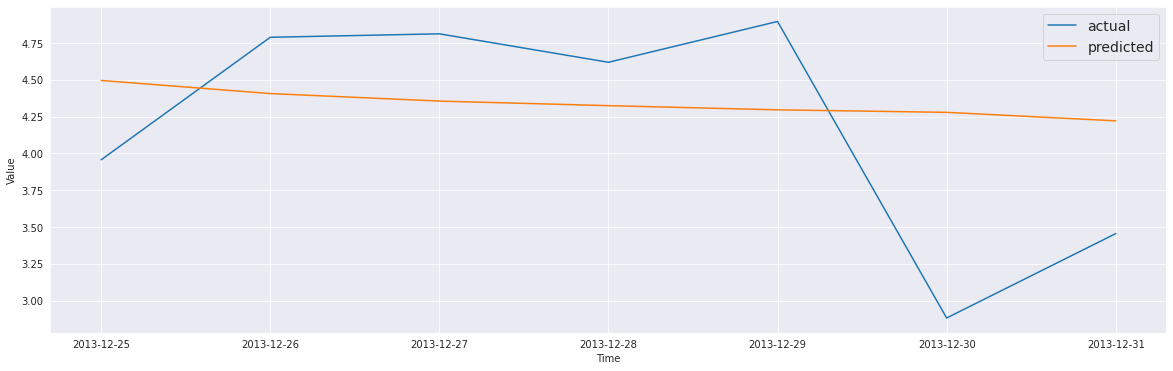

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test[-7:].index, ts_test.values[-7:], label='actual')
plot_series(ts_test[-7:].index, wav5_forecast[-1,-1,:], label='predicted')

In [ ]:
mae=keras.metrics.mean_absolute_error(ts_test.values[:7].flatten(), wav5_forecast[-1,-1,:]).numpy()
mae

1.702376

In [ ]:
mse=keras.metrics.mean_squared_error(ts_test.values[:7].flatten(), wav5_forecast[-1,-1,:]).numpy()
mse

3.057243

In [ ]:
import math
rmse=math.sqrt(rmse)
rmse
# 1.74

0.9400892339270869

In [ ]:
results['WaveNet13-7']=[mae, mse, rmse]

## 10 steps ahead

In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=10)
valid_set=window_dataset_eachstep(ts_test,target_length=10)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Adam(learning_rate=3e-3)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                    callbacks=[lr_schedule]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/20
6900/6900 [==============================] - 42s 6ms/step - loss: 1.3588 - last_time_step_mse: 1.2255 - val_loss: 0.9301 - val_last_time_step_mse: 0.9223 - lr: 1.0000e-04
Epoch 2/20
6900/6900 [==============================] - 39s 5ms/step - loss: 0.8180 - last_time_step_mse: 0.8020 - val_loss: 0.9143 - val_last_time_step_mse: 0.9059 - lr: 1.0798e-04
Epoch 3/20
6900/6900 [==============================] - 39s 6ms/step - loss: 0.8124 - last_time_step_mse: 0.7978 - val_loss: 0.9138 - val_last_time_step_mse: 0.8979 - lr: 1.1659e-04
Epoch 4/20
6900/6900 [==============================] - 39s 6ms/step - loss: 0.8055 - last_time_step_mse: 0.7913 - val_loss: 0.9086 - val_last_time_step_mse: 0.9065 - lr: 1.2589e-04
Epoch 5/20
6900/6900 [==============================] - 39s 6ms/step - loss: 0.8028 - last_time_step_mse: 0.7879 - val_loss: 0.8926 - val_last_time_step_mse: 0.8837 - lr: 1.3594e-04
Epoch 6/20
6900/6900 [==============================] - 39s 6ms/step - loss: 0.7977 - last

(1e-05, 0.1, 0.0, 3.0)

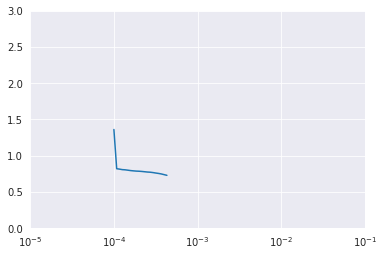

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 3])


In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=10)
valid_set=window_dataset_eachstep(ts_test,target_length=10)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))


optimizer = keras.optimizers.Adam(learning_rate=2e-4)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                   # callbacks=[lr_schedule]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/20
6900/6900 [==============================] - 42s 6ms/step - loss: 1.1192 - last_time_step_mse: 1.0514 - val_loss: 0.9594 - val_last_time_step_mse: 0.9539
Epoch 2/20
6900/6900 [==============================] - 39s 6ms/step - loss: 0.8169 - last_time_step_mse: 0.8002 - val_loss: 0.9182 - val_last_time_step_mse: 0.9082
Epoch 3/20
6900/6900 [==============================] - 39s 6ms/step - loss: 0.8097 - last_time_step_mse: 0.7923 - val_loss: 0.9219 - val_last_time_step_mse: 0.9004
Epoch 4/20
6900/6900 [==============================] - 39s 6ms/step - loss: 0.8009 - last_time_step_mse: 0.7849 - val_loss: 0.9142 - val_last_time_step_mse: 0.9171
Epoch 5/20
6900/6900 [==============================] - 38s 5ms/step - loss: 0.7968 - last_time_step_mse: 0.7795 - val_loss: 0.8885 - val_last_time_step_mse: 0.8826
Epoch 6/20
6900/6900 [==============================] - 39s 6ms/step - loss: 0.7911 - last_time_step_mse: 0.7687 - val_loss: 0.8835 - val_last_time_step_mse: 0.8766
Epoch 7/20

In [ ]:
wav5_forecast = model.predict(valid_set)


In [ ]:
wav5_forecast.shape

(326, 30, 10)

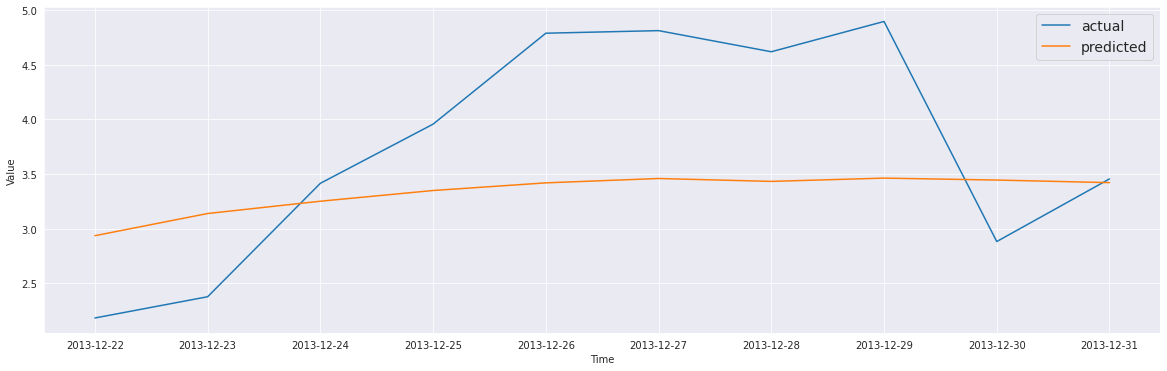

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test[-10:].index, ts_test.values[-10:], label='actual')
plot_series(ts_test[-10:].index, wav5_forecast[-1,-1,:], label='predicted')

In [ ]:
mae=keras.metrics.mean_absolute_error(ts_test.values[:10].flatten(), wav5_forecast[-1,-1,:]).numpy()
mae

2.0045757

In [ ]:
mse=keras.metrics.mean_squared_error(ts_test.values[:10].flatten(), wav5_forecast[-1,-1,:]).numpy()
mse

5.52724

In [ ]:
import math
rmse=math.sqrt(rmse)
rmse
# 2.34

0.96958198927532

In [ ]:
results['WaveNet13-10']=[mae, mse, rmse]

# Wavenet 2014



## Split the dataset: Train/test set  

In [ ]:
# split into train and test sets

split='2011'

ts_recent= (tsf['1993':'2014'])
ts_train=ts_recent[:split]
ts_test=ts_recent['2014-01-01':'2014-12-31']
ts_test

Eto
Data                
2014-01-01  4.797814
2014-01-02  5.712979
2014-01-03  5.624844
2014-01-04  5.516183
2014-01-05  5.727822
...              ...
2014-12-27  6.052921
2014-12-28  5.563148
2014-12-29  5.138635
2014-12-30  5.370926
2014-12-31  4.864127

[365 rows x 1 columns]

## 3 steps ahead

In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=3)
valid_set=window_dataset_eachstep(ts_test,target_length=3)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=3, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Adam(learning_rate=3e-3)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                    callbacks=[lr_schedule]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/20
6907/6907 [==============================] - 38s 5ms/step - loss: 1.1063 - last_time_step_mse: 0.9980 - val_loss: 0.6661 - val_last_time_step_mse: 0.6731 - lr: 1.0000e-04
Epoch 2/20
6907/6907 [==============================] - 35s 5ms/step - loss: 0.6712 - last_time_step_mse: 0.6567 - val_loss: 0.6545 - val_last_time_step_mse: 0.6653 - lr: 1.0798e-04
Epoch 3/20
6907/6907 [==============================] - 36s 5ms/step - loss: 0.6680 - last_time_step_mse: 0.6556 - val_loss: 0.6692 - val_last_time_step_mse: 0.6867 - lr: 1.1659e-04
Epoch 4/20
6907/6907 [==============================] - 36s 5ms/step - loss: 0.6656 - last_time_step_mse: 0.6545 - val_loss: 0.6881 - val_last_time_step_mse: 0.6844 - lr: 1.2589e-04
Epoch 5/20
6907/6907 [==============================] - 36s 5ms/step - loss: 0.6643 - last_time_step_mse: 0.6530 - val_loss: 0.6653 - val_last_time_step_mse: 0.6782 - lr: 1.3594e-04
Epoch 6/20
6907/6907 [==============================] - 36s 5ms/step - loss: 0.6627 - last

(1e-05, 0.1, 0.0, 3.0)

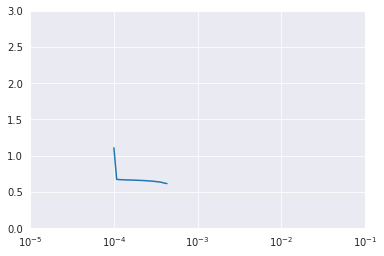

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 3])

In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=3)
valid_set=window_dataset_eachstep(ts_test,target_length=3)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=3, kernel_size=1))


optimizer = keras.optimizers.Adam(learning_rate=2e-4)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                   # callbacks=[lr_schedule]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/20
6907/6907 [==============================] - 38s 5ms/step - loss: 0.9113 - last_time_step_mse: 0.8563 - val_loss: 0.6728 - val_last_time_step_mse: 0.6818
Epoch 2/20
6907/6907 [==============================] - 36s 5ms/step - loss: 0.6707 - last_time_step_mse: 0.6580 - val_loss: 0.6563 - val_last_time_step_mse: 0.6709
Epoch 3/20
6907/6907 [==============================] - 36s 5ms/step - loss: 0.6666 - last_time_step_mse: 0.6531 - val_loss: 0.6598 - val_last_time_step_mse: 0.6759
Epoch 4/20
6907/6907 [==============================] - 36s 5ms/step - loss: 0.6626 - last_time_step_mse: 0.6518 - val_loss: 0.6925 - val_last_time_step_mse: 0.6855
Epoch 5/20
6907/6907 [==============================] - 36s 5ms/step - loss: 0.6597 - last_time_step_mse: 0.6489 - val_loss: 0.6701 - val_last_time_step_mse: 0.6825
Epoch 6/20
6907/6907 [==============================] - 36s 5ms/step - loss: 0.6562 - last_time_step_mse: 0.6402 - val_loss: 0.6491 - val_last_time_step_mse: 0.6675
Epoch 7/20

In [ ]:
wav5_forecast = model.predict(valid_set)

In [ ]:
wav5_forecast.shape

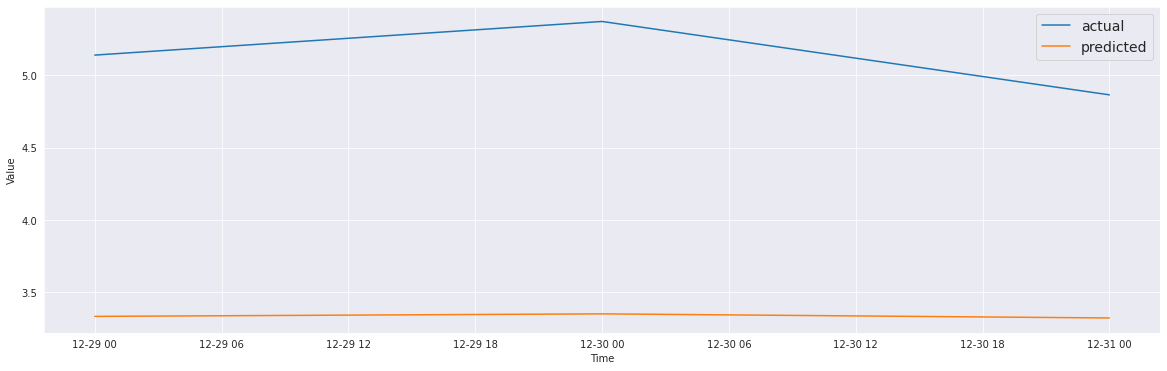

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test[-3:].index, ts_test.values[-3:], label='actual')
plot_series(ts_test[-3:].index, wav5_forecast[-1,-1,:], label='predicted')

In [ ]:
mae=keras.metrics.mean_absolute_error(ts_test.values[:3].flatten(), wav5_forecast[-1,-1,:]).numpy()
mae

2.0424244

In [ ]:
mse=keras.metrics.mean_squared_error(ts_test.values[:3].flatten(), wav5_forecast[-1,-1,:]).numpy()
mse

4.33948

In [ ]:
import math
rmse=math.sqrt(mse)
rmse

2.0831418394454784

In [ ]:
results['WaveNet14-3']=[mae, mse, rmse]

## 7 steps ahead

In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=7)
valid_set=window_dataset_eachstep(ts_test,target_length=7)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=7, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Adam(learning_rate=3e-3)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                    callbacks=[lr_schedule]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/20
6903/6903 [==============================] - 52s 7ms/step - loss: 1.2882 - last_time_step_mse: 1.1163 - val_loss: 0.7507 - val_last_time_step_mse: 0.7581 - lr: 1.0000e-04
Epoch 2/20
6903/6903 [==============================] - 36s 5ms/step - loss: 0.7797 - last_time_step_mse: 0.7607 - val_loss: 0.7436 - val_last_time_step_mse: 0.7633 - lr: 1.0798e-04
Epoch 3/20
6903/6903 [==============================] - 37s 5ms/step - loss: 0.7714 - last_time_step_mse: 0.7504 - val_loss: 0.7348 - val_last_time_step_mse: 0.7513 - lr: 1.1659e-04
Epoch 4/20
6903/6903 [==============================] - 38s 5ms/step - loss: 0.7656 - last_time_step_mse: 0.7436 - val_loss: 0.7406 - val_last_time_step_mse: 0.7498 - lr: 1.2589e-04
Epoch 5/20
6903/6903 [==============================] - 37s 5ms/step - loss: 0.7615 - last_time_step_mse: 0.7429 - val_loss: 0.7613 - val_last_time_step_mse: 0.7833 - lr: 1.3594e-04
Epoch 6/20
6903/6903 [==============================] - 37s 5ms/step - loss: 0.7578 - last

(1e-05, 0.1, 0.0, 3.0)

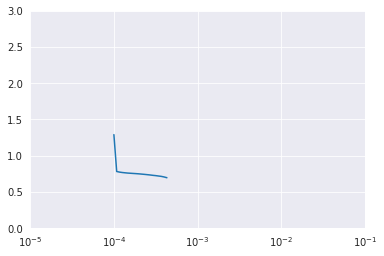

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 3])


In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=7)
valid_set=window_dataset_eachstep(ts_test,target_length=7)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=7, kernel_size=1))


optimizer = keras.optimizers.Adam(learning_rate=2e-4)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                   # callbacks=[lr_schedule]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/20
6903/6903 [==============================] - 38s 5ms/step - loss: 1.0646 - last_time_step_mse: 0.9702 - val_loss: 0.7554 - val_last_time_step_mse: 0.7609
Epoch 2/20
6903/6903 [==============================] - 37s 5ms/step - loss: 0.7759 - last_time_step_mse: 0.7589 - val_loss: 0.7449 - val_last_time_step_mse: 0.7612
Epoch 3/20
6903/6903 [==============================] - 36s 5ms/step - loss: 0.7671 - last_time_step_mse: 0.7462 - val_loss: 0.7359 - val_last_time_step_mse: 0.7500
Epoch 4/20
6903/6903 [==============================] - 37s 5ms/step - loss: 0.7605 - last_time_step_mse: 0.7390 - val_loss: 0.7340 - val_last_time_step_mse: 0.7393
Epoch 5/20
6903/6903 [==============================] - 37s 5ms/step - loss: 0.7554 - last_time_step_mse: 0.7350 - val_loss: 0.7693 - val_last_time_step_mse: 0.7902
Epoch 6/20
6903/6903 [==============================] - 37s 5ms/step - loss: 0.7492 - last_time_step_mse: 0.7293 - val_loss: 0.7430 - val_last_time_step_mse: 0.7529
Epoch 7/20

In [ ]:
wav5_forecast = model.predict(valid_set)


In [ ]:
wav5_forecast.shape

(329, 30, 7)

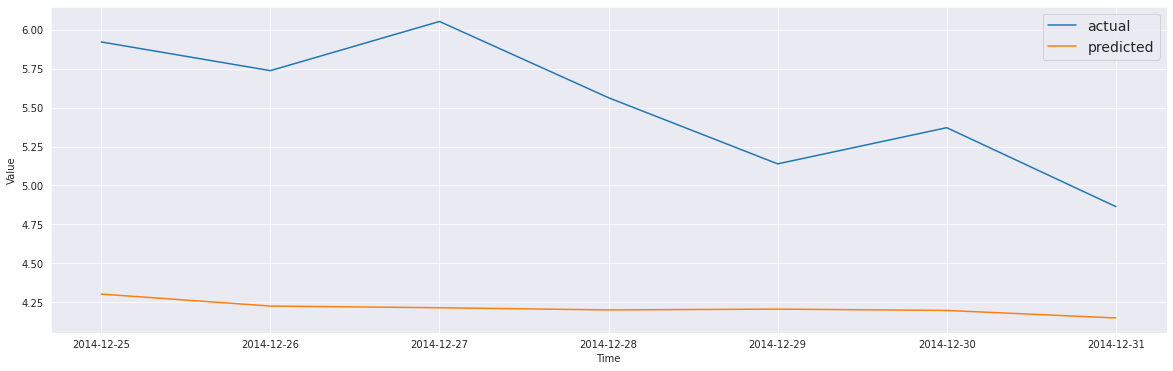

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test[-7:].index, ts_test.values[-7:], label='actual')
plot_series(ts_test[-7:].index, wav5_forecast[-1,-1,:], label='predicted')

In [ ]:
mae=keras.metrics.mean_absolute_error(ts_test.values[:7].flatten(), wav5_forecast[-1,-1,:]).numpy()
mae

1.3650349

In [ ]:
mse=keras.metrics.mean_squared_error(ts_test.values[:7].flatten(), wav5_forecast[-1,-1,:]).numpy()
mse

2.0053952

In [ ]:
import math
rmse=math.sqrt(mse)
rmse

1.4161197597754538

In [ ]:
results['WaveNet14-7']=[mae, mse, rmse]

## 10 steps ahead

In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=10)
valid_set=window_dataset_eachstep(ts_test,target_length=10)

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Adam(learning_rate=3e-3)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                    callbacks=[lr_schedule]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/20
6900/6900 [==============================] - 38s 5ms/step - loss: 1.3588 - last_time_step_mse: 1.2255 - val_loss: 0.9301 - val_last_time_step_mse: 0.9223 - lr: 1.0000e-04
Epoch 2/20
6900/6900 [==============================] - 36s 5ms/step - loss: 0.8180 - last_time_step_mse: 0.8020 - val_loss: 0.9143 - val_last_time_step_mse: 0.9059 - lr: 1.0798e-04
Epoch 3/20
6900/6900 [==============================] - 36s 5ms/step - loss: 0.8124 - last_time_step_mse: 0.7978 - val_loss: 0.9137 - val_last_time_step_mse: 0.8979 - lr: 1.1659e-04
Epoch 4/20
6900/6900 [==============================] - 37s 5ms/step - loss: 0.8054 - last_time_step_mse: 0.7913 - val_loss: 0.9084 - val_last_time_step_mse: 0.9060 - lr: 1.2589e-04
Epoch 5/20
6900/6900 [==============================] - 37s 5ms/step - loss: 0.8028 - last_time_step_mse: 0.7879 - val_loss: 0.8926 - val_last_time_step_mse: 0.8838 - lr: 1.3594e-04
Epoch 6/20
6900/6900 [==============================] - 37s 5ms/step - loss: 0.7973 - last

(1e-05, 0.1, 0.0, 3.0)

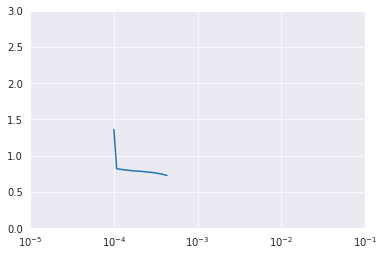

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 3])


In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=10)
valid_set=window_dataset_eachstep(ts_test,target_length=10)

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))


optimizer = keras.optimizers.Adam(learning_rate=2e-4)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                   # callbacks=[lr_schedule]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/20
6900/6900 [==============================] - 39s 5ms/step - loss: 1.1192 - last_time_step_mse: 1.0514 - val_loss: 0.9594 - val_last_time_step_mse: 0.9539
Epoch 2/20
6900/6900 [==============================] - 36s 5ms/step - loss: 0.8169 - last_time_step_mse: 0.8002 - val_loss: 0.9181 - val_last_time_step_mse: 0.9080
Epoch 3/20
6900/6900 [==============================] - 36s 5ms/step - loss: 0.8097 - last_time_step_mse: 0.7922 - val_loss: 0.9218 - val_last_time_step_mse: 0.9002
Epoch 4/20
6900/6900 [==============================] - 36s 5ms/step - loss: 0.8009 - last_time_step_mse: 0.7849 - val_loss: 0.9139 - val_last_time_step_mse: 0.9164
Epoch 5/20
6900/6900 [==============================] - 37s 5ms/step - loss: 0.7968 - last_time_step_mse: 0.7793 - val_loss: 0.8884 - val_last_time_step_mse: 0.8819
Epoch 6/20
6900/6900 [==============================] - 36s 5ms/step - loss: 0.7911 - last_time_step_mse: 0.7688 - val_loss: 0.8829 - val_last_time_step_mse: 0.8760
Epoch 7/20

In [ ]:
wav5_forecast = model.predict(valid_set)


In [ ]:
wav5_forecast.shape

(326, 30, 10)

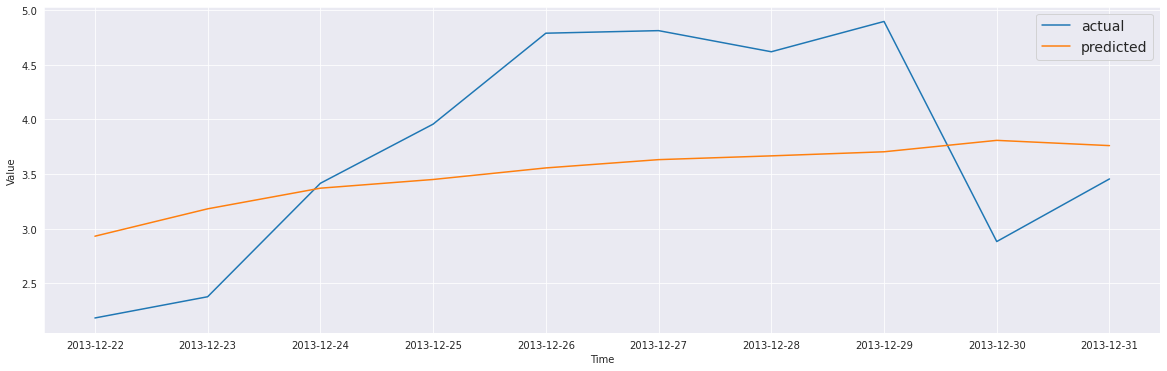

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test[-10:].index, ts_test.values[-10:], label='actual')
plot_series(ts_test[-10:].index, wav5_forecast[-1,-1,:], label='predicted')

In [ ]:
mae=keras.metrics.mean_absolute_error(ts_test.values[:10].flatten(), wav5_forecast[-1,-1,:]).numpy()
mae

1.9473499

In [ ]:
mse=keras.metrics.mean_squared_error(ts_test.values[:10].flatten(), wav5_forecast[-1,-1,:]).numpy()
mse

5.1706324

In [ ]:
import math
rmse=math.sqrt(rmse)
rmse

1.318752273361705

In [ ]:
results['WaveNet14-10']=[mae, mse, rmse]

## 1 step ahead

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = sequential_window_dataset(     list(ts_train.values.flatten())     , window_size)
valid_set = sequential_window_dataset(        list(ts_test.values.flatten())            , window_size)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, 
                                  kernel_size=2, 
                                  padding="causal",
                                  activation="relu", 
                                  dilation_rate=rate))
    
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Adam(learning_rate=3e-3)

model.compile(loss='mse',
              optimizer=optimizer, 
              metrics=['mae'])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                    callbacks=[lr_schedule]
                    )

Epoch 1/20
231/231 [==============================] - 17s 17ms/step - loss: 8.5829 - mae: 2.5566 - val_loss: 3.4806 - val_mae: 1.4452 - lr: 1.0000e-04
Epoch 2/20
231/231 [==============================] - 1s 6ms/step - loss: 2.0933 - mae: 1.0738 - val_loss: 1.4888 - val_mae: 0.9112 - lr: 1.0798e-04
Epoch 3/20
231/231 [==============================] - 1s 6ms/step - loss: 1.0074 - mae: 0.7459 - val_loss: 0.9985 - val_mae: 0.7690 - lr: 1.1659e-04
Epoch 4/20
231/231 [==============================] - 1s 6ms/step - loss: 0.7066 - mae: 0.6420 - val_loss: 0.7944 - val_mae: 0.6842 - lr: 1.2589e-04
Epoch 5/20
231/231 [==============================] - 1s 5ms/step - loss: 0.6018 - mae: 0.5937 - val_loss: 0.7252 - val_mae: 0.6531 - lr: 1.3594e-04
Epoch 6/20
231/231 [==============================] - 1s 6ms/step - loss: 0.5688 - mae: 0.5734 - val_loss: 0.6820 - val_mae: 0.6320 - lr: 1.4678e-04
Epoch 7/20
231/231 [==============================] - 1s 6ms/step - loss: 0.5504 - mae: 0.5598 - val_los

(0.0001, 0.1, 0.0, 30.0)

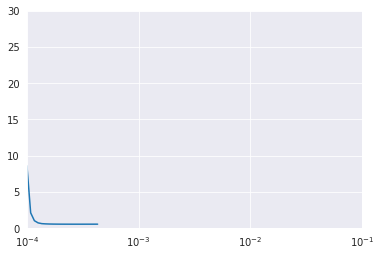

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = sequential_window_dataset(     list(ts_train.values.flatten())     , window_size)
valid_set = sequential_window_dataset(        list(ts_test.values.flatten())            , window_size)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, 
                                  kernel_size=2, 
                                  padding="causal",
                                  activation="relu", 
                                  dilation_rate=rate))
    
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))


optimizer = keras.optimizers.Adam(learning_rate=6.5e-4)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint_wvn1.h5", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer, 
              metrics='mae')

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                     callbacks=[early_stopping, model_checkpoint])
                    

Epoch 1/20
231/231 [==============================] - 4s 8ms/step - loss: 0.7776 - mae: 1.1596 - val_loss: 0.3438 - val_mae: 0.6849
Epoch 2/20
231/231 [==============================] - 1s 6ms/step - loss: 0.2624 - mae: 0.5784 - val_loss: 0.2904 - val_mae: 0.6148
Epoch 3/20
231/231 [==============================] - 1s 6ms/step - loss: 0.2421 - mae: 0.5432 - val_loss: 0.2776 - val_mae: 0.5943
Epoch 4/20
231/231 [==============================] - 1s 6ms/step - loss: 0.2386 - mae: 0.5359 - val_loss: 0.2766 - val_mae: 0.5931
Epoch 5/20
231/231 [==============================] - 1s 6ms/step - loss: 0.2372 - mae: 0.5332 - val_loss: 0.2777 - val_mae: 0.5944
Epoch 6/20
231/231 [==============================] - 1s 6ms/step - loss: 0.2366 - mae: 0.5322 - val_loss: 0.2762 - val_mae: 0.5926
Epoch 7/20
231/231 [==============================] - 1s 6ms/step - loss: 0.2360 - mae: 0.5312 - val_loss: 0.2764 - val_mae: 0.5928
Epoch 8/20
231/231 [==============================] - 1s 6ms/step - loss: 0.

In [ ]:
model = keras.models.load_model("my_checkpoint_wvn1.h5")

In [ ]:
wavenet_forecast = model.predict( ts_recent.values.flatten()[np.newaxis, :, np.newaxis])
#rnn_forecast = rnn_forecast[0, len(ts_train)-1 :-1, 0]

In [ ]:
wavenet_forecast.shape

(365,)

In [ ]:
wavenet_forecast = wavenet_forecast[0, len(ts_train)+len(tsf['2012':'2013'])-1 :-1,0]

wavenet_forecast.shape

(365,)

In [ ]:
len(ts_train)

6939

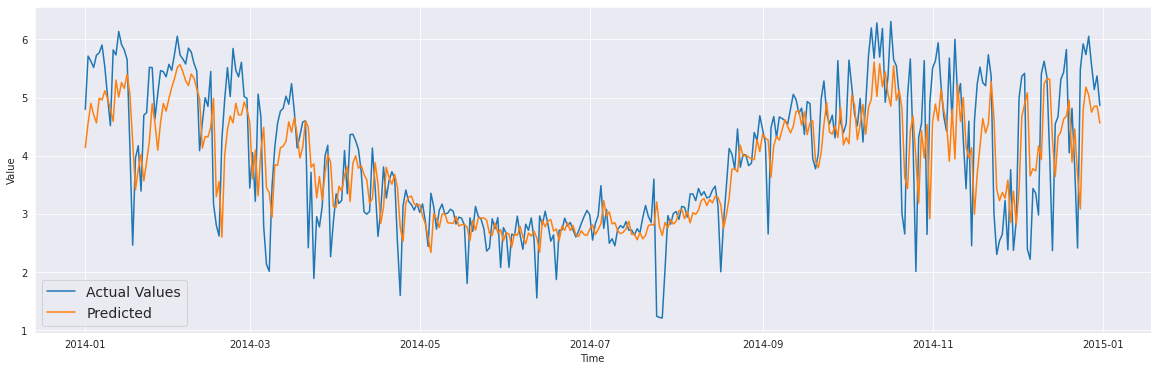

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test.index, ts_test.values, label='Actual Values')
plot_series(ts_test.index, wavenet_forecast, label='Predicted')

In [ ]:
wavenet_forecast[-5:-1,]

array([5.0411587, 4.7495594, 4.848681 , 4.853058 ], dtype=float32)

In [ ]:
ts.tail()

In [ ]:
mae=keras.metrics.mean_absolute_error(ts_test.values.flatten(), wavenet_forecast).numpy()
mae

0.5646824

In [ ]:
mse=keras.metrics.mean_squared_error(ts_test.values.flatten(), wavenet_forecast).numpy()
mse

0.58385843

In [ ]:
import math
rmse=math.sqrt(mse)
rmse

0.764106295213951

In [ ]:
results['WaveNet14-1']=[mae, mse, rmse]

# Wavenet 2015



## Split the dataset: Train/test set  

In [ ]:
# split into train and test sets

split='2011'

ts_recent= (tsf['1993':'2015'])
ts_train=ts_recent[:split]
ts_test=ts_recent['2015-01-01':'2015-12-31']
ts_test

Eto
Data                
2015-01-01  5.107780
2015-01-02  4.808586
2015-01-03  5.332205
2015-01-04  4.685551
2015-01-05  5.773314
...              ...
2015-12-27  2.633047
2015-12-28  3.445454
2015-12-29  2.556850
2015-12-30  2.636948
2015-12-31  5.705485

[365 rows x 1 columns]

## 3 steps ahead

In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=3)
valid_set=window_dataset_eachstep(ts_test,target_length=3)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=3, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Adam(learning_rate=3e-3)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                    callbacks=[lr_schedule]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/20
6907/6907 [==============================] - 50s 5ms/step - loss: 1.1063 - last_time_step_mse: 0.9980 - val_loss: 0.6691 - val_last_time_step_mse: 0.6708 - lr: 1.0000e-04
Epoch 2/20
6907/6907 [==============================] - 38s 5ms/step - loss: 0.6712 - last_time_step_mse: 0.6569 - val_loss: 0.6602 - val_last_time_step_mse: 0.6608 - lr: 1.0798e-04
Epoch 3/20
6907/6907 [==============================] - 37s 5ms/step - loss: 0.6680 - last_time_step_mse: 0.6558 - val_loss: 0.6642 - val_last_time_step_mse: 0.6644 - lr: 1.1659e-04
Epoch 4/20
6907/6907 [==============================] - 36s 5ms/step - loss: 0.6658 - last_time_step_mse: 0.6549 - val_loss: 0.6823 - val_last_time_step_mse: 0.6655 - lr: 1.2589e-04
Epoch 5/20
6907/6907 [==============================] - 38s 5ms/step - loss: 0.6644 - last_time_step_mse: 0.6529 - val_loss: 0.6580 - val_last_time_step_mse: 0.6546 - lr: 1.3594e-04
Epoch 6/20
6907/6907 [==============================] - 37s 5ms/step - loss: 0.6627 - last

(1e-05, 0.1, 0.0, 3.0)

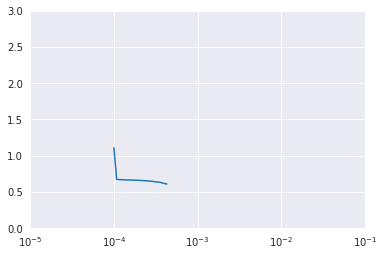

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 3])

In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=3)
valid_set=window_dataset_eachstep(ts_test,target_length=3)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=3, kernel_size=1))


optimizer = keras.optimizers.Adam(learning_rate=2e-4)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                   # callbacks=[lr_schedule]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/20
6907/6907 [==============================] - 38s 5ms/step - loss: 0.9113 - last_time_step_mse: 0.8563 - val_loss: 0.6695 - val_last_time_step_mse: 0.6654
Epoch 2/20
6907/6907 [==============================] - 37s 5ms/step - loss: 0.6707 - last_time_step_mse: 0.6579 - val_loss: 0.6563 - val_last_time_step_mse: 0.6559
Epoch 3/20
6907/6907 [==============================] - 36s 5ms/step - loss: 0.6666 - last_time_step_mse: 0.6532 - val_loss: 0.6547 - val_last_time_step_mse: 0.6535
Epoch 4/20
6907/6907 [==============================] - 36s 5ms/step - loss: 0.6625 - last_time_step_mse: 0.6517 - val_loss: 0.6862 - val_last_time_step_mse: 0.6672
Epoch 5/20
6907/6907 [==============================] - 36s 5ms/step - loss: 0.6598 - last_time_step_mse: 0.6486 - val_loss: 0.6605 - val_last_time_step_mse: 0.6532
Epoch 6/20
6907/6907 [==============================] - 36s 5ms/step - loss: 0.6563 - last_time_step_mse: 0.6406 - val_loss: 0.6493 - val_last_time_step_mse: 0.6471
Epoch 7/20

In [ ]:
wav5_forecast = model.predict(valid_set)


In [ ]:
wav5_forecast.shape

(333, 30, 3)

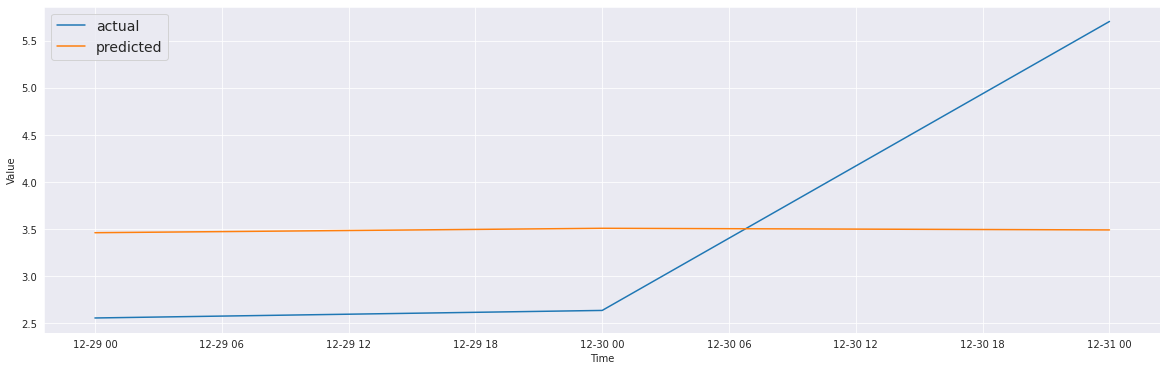

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test[-3:].index, ts_test.values[-3:], label='actual')
plot_series(ts_test[-3:].index, wav5_forecast[-1,-1,:], label='predicted')

In [ ]:
mae=keras.metrics.mean_absolute_error(ts_test.values[:3].flatten(), wav5_forecast[-1,-1,:]).numpy()
mae

1.595102

In [ ]:
mse=keras.metrics.mean_squared_error(ts_test.values[:3].flatten(), wav5_forecast[-1,-1,:]).numpy()
mse

2.5943747

In [ ]:
import math
rmse=math.sqrt(mse)
rmse

1.6107062602092432

In [ ]:
results['WaveNet15-3']=[mae, mse, rmse]

## 7 steps ahead

In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=7)
valid_set=window_dataset_eachstep(ts_test,target_length=7)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=7, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Adam(learning_rate=3e-3)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                    callbacks=[lr_schedule]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/20
6903/6903 [==============================] - 42s 6ms/step - loss: 1.2882 - last_time_step_mse: 1.1163 - val_loss: 0.7682 - val_last_time_step_mse: 0.7601 - lr: 1.0000e-04
Epoch 2/20
6903/6903 [==============================] - 37s 5ms/step - loss: 0.7797 - last_time_step_mse: 0.7607 - val_loss: 0.7536 - val_last_time_step_mse: 0.7504 - lr: 1.0798e-04
Epoch 3/20
6903/6903 [==============================] - 40s 6ms/step - loss: 0.7713 - last_time_step_mse: 0.7503 - val_loss: 0.7471 - val_last_time_step_mse: 0.7393 - lr: 1.1659e-04
Epoch 4/20
6903/6903 [==============================] - 48s 7ms/step - loss: 0.7655 - last_time_step_mse: 0.7435 - val_loss: 0.7430 - val_last_time_step_mse: 0.7335 - lr: 1.2589e-04
Epoch 5/20
6903/6903 [==============================] - 37s 5ms/step - loss: 0.7614 - last_time_step_mse: 0.7427 - val_loss: 0.7538 - val_last_time_step_mse: 0.7511 - lr: 1.3594e-04
Epoch 6/20
6903/6903 [==============================] - 36s 5ms/step - loss: 0.7574 - last

(1e-05, 0.1, 0.0, 3.0)

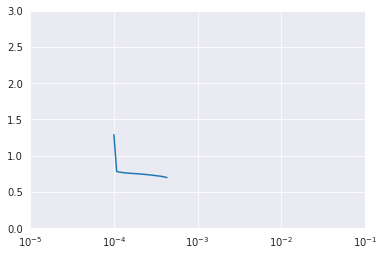

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 3])


In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=7)
valid_set=window_dataset_eachstep(ts_test,target_length=7)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=7, kernel_size=1))

optimizer = keras.optimizers.Adam(learning_rate=2e-4)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                   # callbacks=[lr_schedule]
                    )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/20
6903/6903 [==============================] - 39s 5ms/step - loss: 1.0646 - last_time_step_mse: 0.9701 - val_loss: 0.7634 - val_last_time_step_mse: 0.7531
Epoch 2/20
6903/6903 [==============================] - 37s 5ms/step - loss: 0.7758 - last_time_step_mse: 0.7590 - val_loss: 0.7469 - val_last_time_step_mse: 0.7410
Epoch 3/20
6903/6903 [==============================] - 37s 5ms/step - loss: 0.7673 - last_time_step_mse: 0.7469 - val_loss: 0.7407 - val_last_time_step_mse: 0.7338
Epoch 4/20
6903/6903 [==============================] - 37s 5ms/step - loss: 0.7609 - last_time_step_mse: 0.7395 - val_loss: 0.7349 - val_last_time_step_mse: 0.7238
Epoch 5/20
6903/6903 [==============================] - 37s 5ms/step - loss: 0.7559 - last_time_step_mse: 0.7360 - val_loss: 0.7588 - val_last_time_step_mse: 0.7561
Epoch 6/20
6903/6903 [==============================] - 37s 5ms/step - loss: 0.7505 - last_time_step_mse: 0.7315 - val_loss: 0.7377 - val_last_time_step_mse: 0.7258
Epoch 7/20

In [ ]:
wav5_forecast = model.predict(valid_set)


In [ ]:
wav5_forecast.shape

(329, 30, 7)

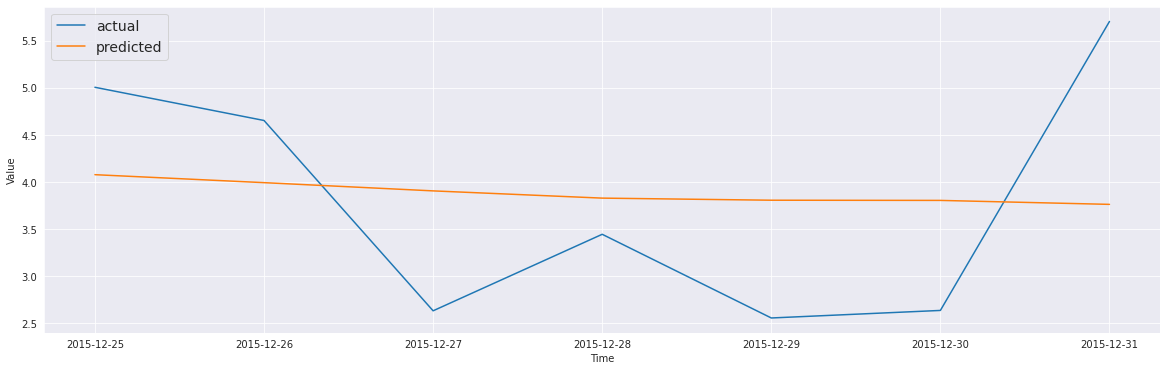

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test[-7:].index, ts_test.values[-7:], label='actual')
plot_series(ts_test[-7:].index, wav5_forecast[-1,-1,:], label='predicted')

In [ ]:
mae=keras.metrics.mean_absolute_error(ts_test.values[:7].flatten(), wav5_forecast[-1,-1,:]).numpy()
mae

1.1931809

In [ ]:
mse=keras.metrics.mean_squared_error(ts_test.values[:7].flatten(), wav5_forecast[-1,-1,:]).numpy()
mse

1.6423547

In [ ]:
import math
rmse=math.sqrt(mse)
rmse
# 1.2815438840677216

1.2815438840677216

In [ ]:
results['WaveNet15-7']=[mae, mse, rmse]

## 10 steps ahead

In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=10)
valid_set=window_dataset_eachstep(ts_test,target_length=10)

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Adam(learning_rate=3e-3)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                    callbacks=[lr_schedule]
                    )

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 3])


In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=10)
valid_set=window_dataset_eachstep(ts_test,target_length=10)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))


optimizer = keras.optimizers.Adam(learning_rate=2e-4)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                   # callbacks=[lr_schedule]
                    )

In [ ]:
wav5_forecast = model.predict(valid_set)


In [ ]:
wav5_forecast.shape

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test[-10:].index, ts_test.values[-10:], label='actual')
plot_series(ts_test[-10:].index, wav5_forecast[-1,-1,:], label='predicted')

In [ ]:
mae=keras.metrics.mean_absolute_error(ts_test.values[:10].flatten(), wav5_forecast[-1,-1,:]).numpy()
mae

In [ ]:
mse=keras.metrics.mean_squared_error(ts_test.values[:10].flatten(), wav5_forecast[-1,-1,:]).numpy()
mse

In [ ]:
import math
rmse=math.sqrt(mse)
rmse

In [ ]:
results['WaveNet15-10']=[mae, mse, rmse]

In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=10)
valid_set=window_dataset_eachstep(ts_test,target_length=10)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Adam(learning_rate=3e-3)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                    callbacks=[lr_schedule]
                    )

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-1, 0, 3])


In [ ]:
train_set=window_dataset_eachstep(ts_train, window_size=30, target_length=10)
valid_set=window_dataset_eachstep(ts_test,target_length=10)


np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))


optimizer = keras.optimizers.Adam(learning_rate=2e-4)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                   # callbacks=[lr_schedule]
                    )

In [ ]:
wav5_forecast = model.predict(valid_set)


In [ ]:
wav5_forecast.shape

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test[-10:].index, ts_test.values[-10:], label='actual')
plot_series(ts_test[-10:].index, wav5_forecast[-1,-1,:], label='predicted')

## 1 step ahead

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = sequential_window_dataset(     list(ts_train.values.flatten())     , window_size)
valid_set = sequential_window_dataset(        list(ts_test.values.flatten())            , window_size)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, 
                                  kernel_size=2, 
                                  padding="causal",
                                  activation="relu", 
                                  dilation_rate=rate))
    
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = keras.optimizers.Adam(learning_rate=3e-3)

model.compile(loss='mse',
              optimizer=optimizer, 
              metrics=['mae'])

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                    callbacks=[lr_schedule]
                    )

Epoch 1/20
231/231 [==============================] - 5s 13ms/step - loss: 8.5829 - mae: 2.5566 - val_loss: 3.6328 - val_mae: 1.4279 - lr: 1.0000e-04
Epoch 2/20
231/231 [==============================] - 2s 10ms/step - loss: 2.0933 - mae: 1.0738 - val_loss: 1.4096 - val_mae: 0.8789 - lr: 1.0798e-04
Epoch 3/20
231/231 [==============================] - 3s 11ms/step - loss: 1.0074 - mae: 0.7459 - val_loss: 0.8816 - val_mae: 0.7184 - lr: 1.1659e-04
Epoch 4/20
231/231 [==============================] - 2s 9ms/step - loss: 0.7066 - mae: 0.6420 - val_loss: 0.6942 - val_mae: 0.6475 - lr: 1.2589e-04
Epoch 5/20
231/231 [==============================] - 2s 10ms/step - loss: 0.6018 - mae: 0.5937 - val_loss: 0.6506 - val_mae: 0.6245 - lr: 1.3594e-04
Epoch 6/20
231/231 [==============================] - 2s 10ms/step - loss: 0.5688 - mae: 0.5734 - val_loss: 0.6282 - val_mae: 0.6130 - lr: 1.4678e-04
Epoch 7/20
231/231 [==============================] - 3s 13ms/step - loss: 0.5504 - mae: 0.5598 - val

(0.0001, 0.1, 0.0, 30.0)

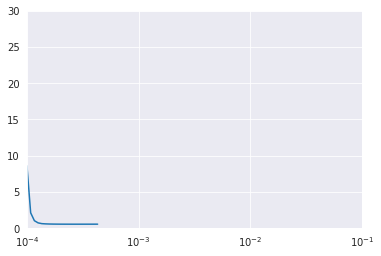

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30

train_set = sequential_window_dataset(     list(ts_train.values.flatten())     , window_size)
valid_set = sequential_window_dataset(        list(ts_test.values.flatten())            , window_size)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, 
                                  kernel_size=2, 
                                  padding="causal",
                                  activation="relu", 
                                  dilation_rate=rate))
    
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))


optimizer = keras.optimizers.Adam(learning_rate=6.5e-4)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint_wvn1.h5", save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=50)

model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer, 
              metrics='mae')

history = model.fit(train_set, epochs=20,
                   validation_data=valid_set,
                     callbacks=[early_stopping, model_checkpoint])
                    

Epoch 1/20
231/231 [==============================] - 3s 8ms/step - loss: 0.7776 - mae: 1.1596 - val_loss: 0.3201 - val_mae: 0.6593
Epoch 2/20
231/231 [==============================] - 1s 6ms/step - loss: 0.2624 - mae: 0.5784 - val_loss: 0.2725 - val_mae: 0.5981
Epoch 3/20
231/231 [==============================] - 1s 6ms/step - loss: 0.2421 - mae: 0.5432 - val_loss: 0.2625 - val_mae: 0.5841
Epoch 4/20
231/231 [==============================] - 1s 6ms/step - loss: 0.2386 - mae: 0.5359 - val_loss: 0.2591 - val_mae: 0.5792
Epoch 5/20
231/231 [==============================] - 1s 6ms/step - loss: 0.2372 - mae: 0.5332 - val_loss: 0.2582 - val_mae: 0.5776
Epoch 6/20
231/231 [==============================] - 1s 6ms/step - loss: 0.2366 - mae: 0.5322 - val_loss: 0.2579 - val_mae: 0.5766
Epoch 7/20
231/231 [==============================] - 1s 6ms/step - loss: 0.2360 - mae: 0.5312 - val_loss: 0.2575 - val_mae: 0.5752
Epoch 8/20
231/231 [==============================] - 1s 6ms/step - loss: 0.

In [ ]:
model = keras.models.load_model("my_checkpoint_wvn1.h5")

In [ ]:
wavenet_forecast = model.predict( ts_recent.values.flatten()[np.newaxis, :, np.newaxis])
#rnn_forecast = rnn_forecast[0, len(ts_train)-1 :-1, 0]

In [ ]:
wavenet_forecast.shape

(1, 8400, 1)

In [ ]:
wavenet_forecast = wavenet_forecast[0, len(ts_train)+len(tsf['2012':'2014'])-1 :-1,0]
wavenet_forecast.shape

(365,)

In [ ]:
len(ts_train)

6939

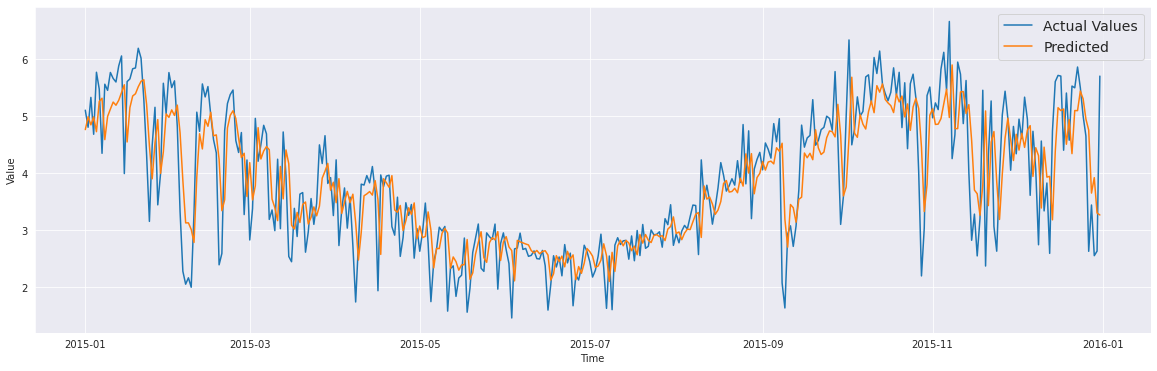

In [ ]:
plt.figure(figsize=(20, 6))
plot_series(ts_test.index, ts_test.values, label='Actual Values')
plot_series(ts_test.index, wavenet_forecast[:], label='Predicted')

In [ ]:
wavenet_forecast[-5:-1,]

array([4.758832 , 3.6544418, 3.9245396, 3.3043664], dtype=float32)

In [ ]:
ts.tail()

Eto
Data                
2015-12-27  2.633047
2015-12-28  3.445454
2015-12-29  2.556850
2015-12-30  2.636948
2015-12-31  5.705485

In [ ]:
mae=keras.metrics.mean_absolute_error(ts_test.values.flatten(), wavenet_forecast).numpy()
mae

0.55026

In [ ]:
mse=keras.metrics.mean_squared_error(ts_test.values.flatten(), wavenet_forecast).numpy()
mse

0.5434812

In [ ]:
import math
rmse=math.sqrt(mse)
rmse

0.737211754607273

In [ ]:
results['WaveNet15-1']=[mae, mse, rmse]

# III. Results/ Comments

In [ ]:
results_df=pd.DataFrame(results)
results_df.index=['MAE', 'MSE', 'RMSE']
results_df=results_df.T
results_df.sort_values(by=['MAE'], inplace=True)

In [ ]:
results_df

Remarks: 

*   The "Naive(daily updated)" model has knowledge of the true price value of the previous day. For this reason, it is not comparable with the other models but it still offers a very high benchmark for other models to beat. 
*   The WaveNet and LSTM algorithms are chosen by ModelCheckpoint based on the best predictions on the validation set, even though are trained exclusively on the training set. Therefore, the table above only gives us a rough idea of the performance of each  method. We could have made it more accurate by setting " monitor='loss' "  but for the purposes of this notebook this wasn't important.

*   The WaveNet beats others, as expected. Also, RNN/LSTM's score could be improved by better training. 